In [1]:
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import pandas as pd
import h5py
import vector
vector.register_numba()
vector.register_awkward()

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)
import matplotlib

# matplotlib.rcParams['font.sans-serif'] = ['Verdana']
matplotlib.rcParams["figure.dpi"] = 300

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Plot the scores of the new trainings for the new cuts

Load data

In [2]:
# prefix="/afs/cern.ch/user/m/mmalucch/public/out_prediction_files/"
# filename_test_nc = prefix +"true_files/output_JetGood_test_allkl_new_kl_newcuts.h5"
# filename_pred_nc= prefix + "spanet_prediction_nc_on_nc_300e.h5"

# filename_test_nc="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_prediction_5_jets.h5"
filename_true_nc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/true_files/output_JetGood_test_allkl_new_kl_newcuts.h5"
filename_true_oc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/true_files/output_JetGood_test_allkl_new_kl_oldcuts.h5"
filename_pred_nc_nc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/spanet_prediction_nc_on_nc_300e.h5"
filename_pred_oc_nc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/spanet_prediction_oc_on_nc.h5" #new events and the full
filename_pred_oc_oc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/spanet_prediction_oc_on_oc_kl3p5.h5" #full proba

df_true_nc = h5py.File(filename_true_nc,'r')
df_true_oc = h5py.File(filename_true_oc,'r')
df_pred_nc_on_nc=h5py.File(filename_pred_nc_nc,'r')
df_pred_oc_on_nc=h5py.File(filename_pred_oc_nc,'r')
df_pred_oc_on_oc=h5py.File(filename_pred_oc_oc,'r')
# df_pred1 = h5py.File(filename_pred1,'r')
# df_pred2 = h5py.File(filename_pred2,'r')

## Computing the efficiency inclusively

In [3]:
# Creating a dictionary with the value of the inidces for each b quark

def preselection(dataset,label):   
    b_jet_dict={
        f"index_b1_{label}":dataset["TARGETS"]["h1"]["b1"][()],
        f"index_b2_{label}":dataset["TARGETS"]["h1"]["b2"][()],
        f"index_b3_{label}":dataset["TARGETS"]["h2"]["b3"][()],
        f"index_b4_{label}":dataset["TARGETS"]["h2"]["b4"][()],
        f"pt_{label}":dataset["INPUTS"]["Jet"]["ptPnetRegNeutrino"][()], 
    }
    return b_jet_dict

true_nc= preselection(df_true_nc, "true_new_cuts")
pred_nc= preselection(df_pred_nc_on_nc, "pred_new_cuts")

#function to filter the b quark wanted in the dictionary

def filter_dataset(datasets, key):
    for dataset in datasets:
        if key in dataset:
            return dataset
    print("No dataset contains both keys.")
    return ""

print(true_nc[filter_dataset(preselection(df_true_nc, "true_new_cuts"), "pt")])

    

[[ 381.4775     56.97494    32.19304   248.06146    62.47574 ]
 [  69.26364   198.60654    57.017525   56.054173   63.21484 ]
 [ 187.8155    220.62973   115.562454   35.725597   51.955   ]
 ...
 [ 206.20268    49.492634   93.74173   130.76738  9999.      ]
 [  79.936485   61.103214  157.19423    69.72033   149.54793 ]
 [ 113.44733    86.918686  113.63911   155.72134    45.57558 ]]


In [4]:
#Function to compute the efficiemcies inclusively

def mask_35_h_on_pred(dataset, dataset_pred,label, label_pred):
    
    #Apply the mask of 35 GeV in the pt in the truth dataset (or pred as well)
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    mask_pt_35=ak.any(presel[pt]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    
    #Define the b quark indices of the truth dataset where the mask is applied
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_pt_35]
    
    
    #Same procedure but with the prdiction dataset
    presel_pred=preselection(dataset_pred, label_pred)
    pt_pred= filter_dataset(presel_pred, "pt")
    mask_pt_35=ak.any(presel_pred[pt_pred]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask_pred= presel_pred[filter_dataset(presel_pred, "b1")][mask_pt_35]
    idx_b2_mask_pred= presel_pred[filter_dataset(presel_pred, "b2")][mask_pt_35]
    idx_b3_mask_pred= presel_pred[filter_dataset(presel_pred, "b3")][mask_pt_35]
    idx_b4_mask_pred= presel_pred[filter_dataset(presel_pred, "b4")][mask_pt_35]
    
    # print(len(idx_b1_mask))
    #Since we want elements of the same lenght, what we want is to keep the events of the prediction file for which one of the matched jets is below 35 GeV, therefore we define the mask with the prediction files and apply that selection to the truth files
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=presel_pred[pt_pred][mask_pt_35]
    
    #mask the veents where each jets corresponding to the b quark is below 35 so that the recontructed Higgs will have  a jet with pt lower than 35
    mask_b1= pt_mask[row_indices,idx_b1_mask_pred ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask_pred ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask_pred ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask_pred ]< 35
    
    #Apply to the truth dataset. Since we want the di higgs efficiency we want H1 and H2 to have the same lenmght so we apply the 4 masks. 
    idx_b1_35= idx_b1_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b2_35= idx_b2_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b3_35= idx_b3_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b4_35= idx_b4_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    
    # print(len(idx_b1_35))
    
    idx_h1= ak.concatenate((ak.unflatten(idx_b1_35, ak.ones_like(idx_b1_35)), ak.unflatten(idx_b2_35, ak.ones_like(idx_b2_35))), axis=1)
    idx_h2= ak.concatenate((ak.unflatten(idx_b3_35, ak.ones_like(idx_b3_35)), ak.unflatten(idx_b4_35, ak.ones_like(idx_b4_35))), axis=1)
    
    idx_h1_order = ak.sort(idx_h1, axis=1)
    idx_h2_order= ak.sort(idx_h2, axis=1)
    
    idx_h= ak.concatenate((ak.unflatten(idx_h1_order, ak.ones_like(idx_h1_order[:,0])), ak.unflatten(idx_h2_order, ak.ones_like(idx_h2_order[:,0]))), axis=1)
    
    return idx_h1, idx_h2 , idx_h
    
idx_nc_nc_pred_h1, idx_nc_nc_pred_h2, idx_nc_nc_pred_h =mask_35_h_on_pred(df_pred_nc_on_nc, df_pred_nc_on_nc, "pred_nc", "pred_nc")
idx_nc_nc_true_h1, idx_nc_nc_true_h2, idx_nc_nc_true_h=mask_35_h_on_pred(df_true_nc, df_pred_nc_on_nc,"true_nc", "pred_nc")

idx_oc_nc_true_h1, idx_oc_nc_true_h2, idx_oc_nc_true_h=mask_35_h_on_pred(df_true_nc, df_pred_oc_on_nc,"true_nc", "pred_oc_nc")
idx_oc_nc_pred_h1, idx_oc_nc_pred_h2, idx_oc_nc_pred_h =mask_35_h_on_pred(df_pred_oc_on_nc, df_pred_oc_on_nc, "pred_oc_nc", "pred_oc_nc")

idx_oc_oc_pred_h1, idx_oc_oc_pred_h2, idx_oc_oc_pred_h =mask_35_h_on_pred(df_pred_oc_on_oc, df_pred_oc_on_oc, "pred_oc_oc", "pred_oc_oc")
idx_oc_oc_true_h1, idx_oc_oc_true_h2, idx_oc_oc_true_h=mask_35_h_on_pred(df_true_oc, df_pred_oc_on_oc,"true_oc", "pred_oc_oc")


# ak.all(idx_nc_pred_h1_pred==idx_nc_true_h1_pred,axis=1)
 

In [5]:

idx_h=[[idx_nc_nc_pred_h, idx_nc_nc_true_h],[idx_oc_nc_pred_h, idx_oc_nc_true_h],[idx_oc_oc_pred_h, idx_oc_oc_true_h]]

for i in idx_h:
    correctly_fully_matched = (
        ak.all(
            i[0][:, 0] == i[1][:, 0],
            axis=1,
        )
        | ak.all(
            i[0][:, 0] == i[1][:, 1],
            axis=1,
        )
        | ak.all(
            i[0][:, 1] == i[1][:, 0],
            axis=1,
        )
        | ak.all(
            i[0][:, 1] == i[1][:, 1],
            axis=1,
        )
    )
    print(ak.sum(correctly_fully_matched) / len(i[0]))

0.874456372541937
0.8633269532430526
nan


/tmp/ramellar/ipykernel_3304099/2821575099.py:22: RuntimeWarning: invalid value encountered in scalar divide
  print(ak.sum(correctly_fully_matched) / len(i[0]))


## Plotting the assignment probability

In [6]:
df_pred_nc_on_nc["TARGETS"].keys()
print(df_pred_nc_on_nc["TARGETS"]["h1"].keys())
print(df_pred_nc_on_nc["TARGETS"]["h1"]["assignment_probability"][()])
print(df_pred_nc_on_nc["INPUTS"]["Jet"].keys())

<KeysViewHDF5 ['assignment_probability', 'b1', 'b2', 'detection_probability', 'marginal_probability']>
[0.99674165 0.99940735 0.4177115  ... 0.99999356 0.9954484  0.99816495]
<KeysViewHDF5 ['MASK', 'btag', 'btag_wp_bit', 'cosPhi', 'eta', 'mass', 'phi', 'pt', 'ptPnetRegNeutrino', 'sinPhi']>


[0.99674165 0.99940735 0.4177115  ... 0.99999356 0.9954484  0.99816495]
[0.99986196 0.9917316  0.99990857 ... 0.9999995  0.99059445 0.99522984]
419287
419287


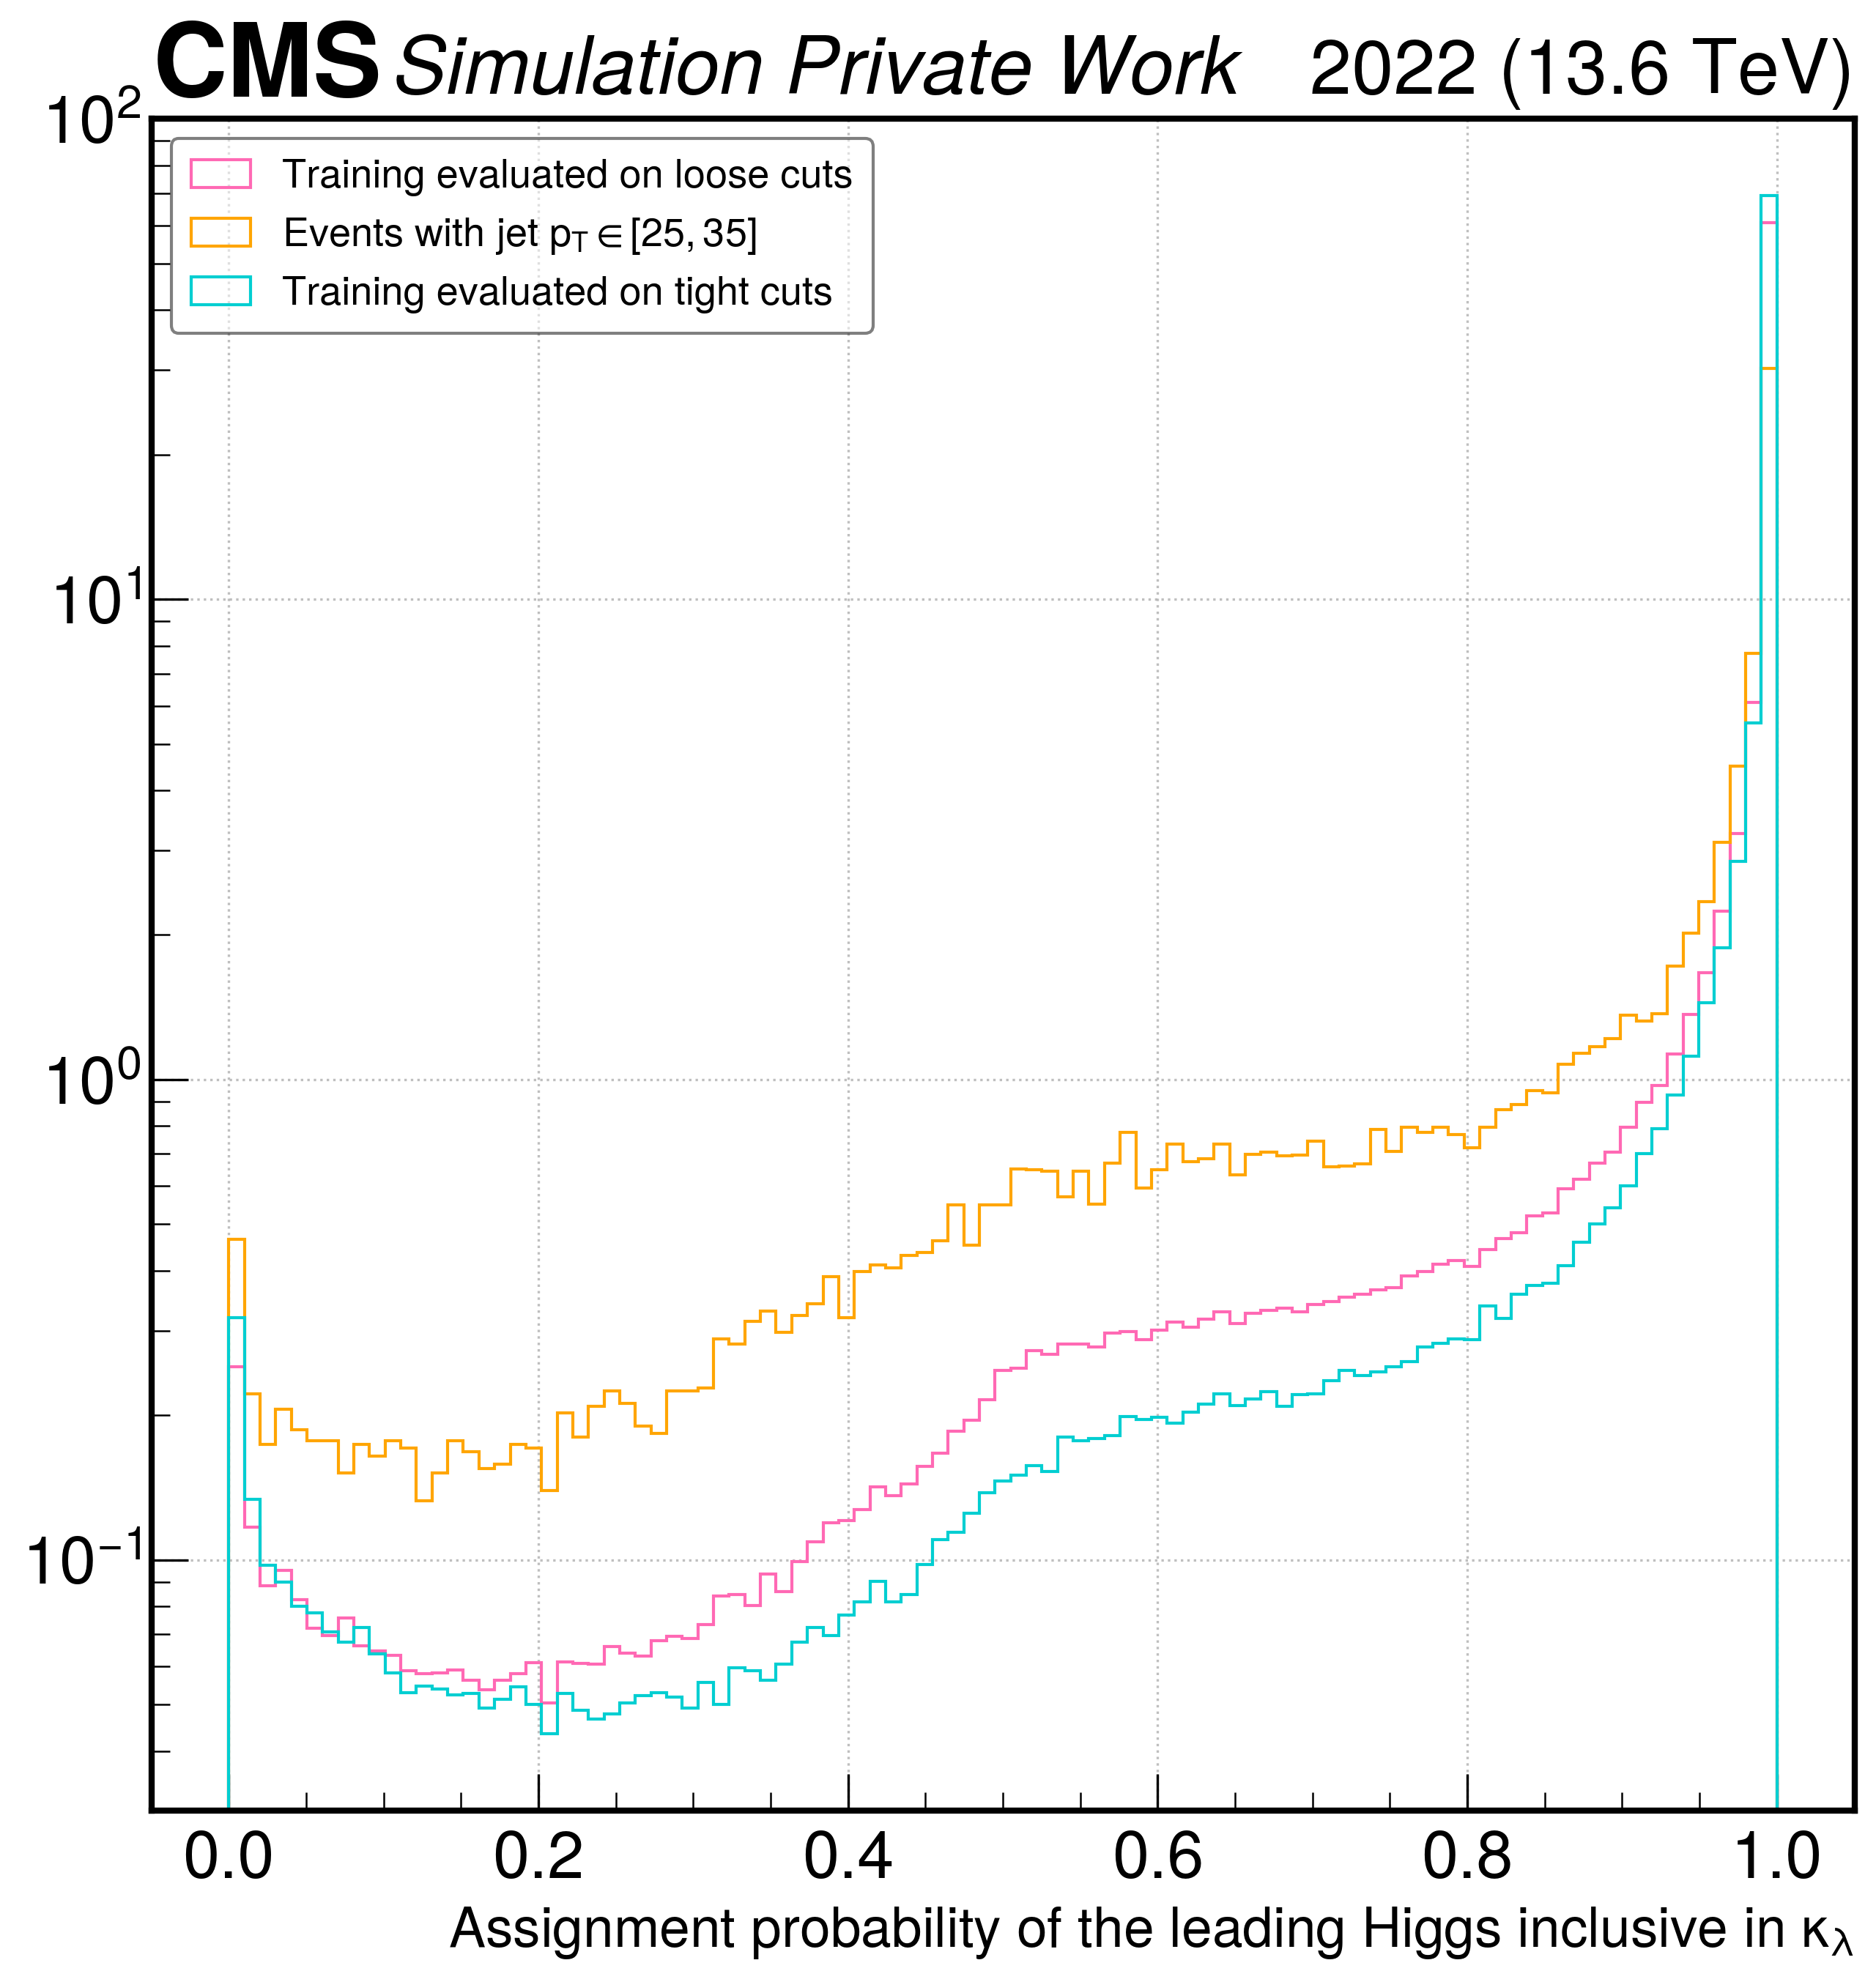

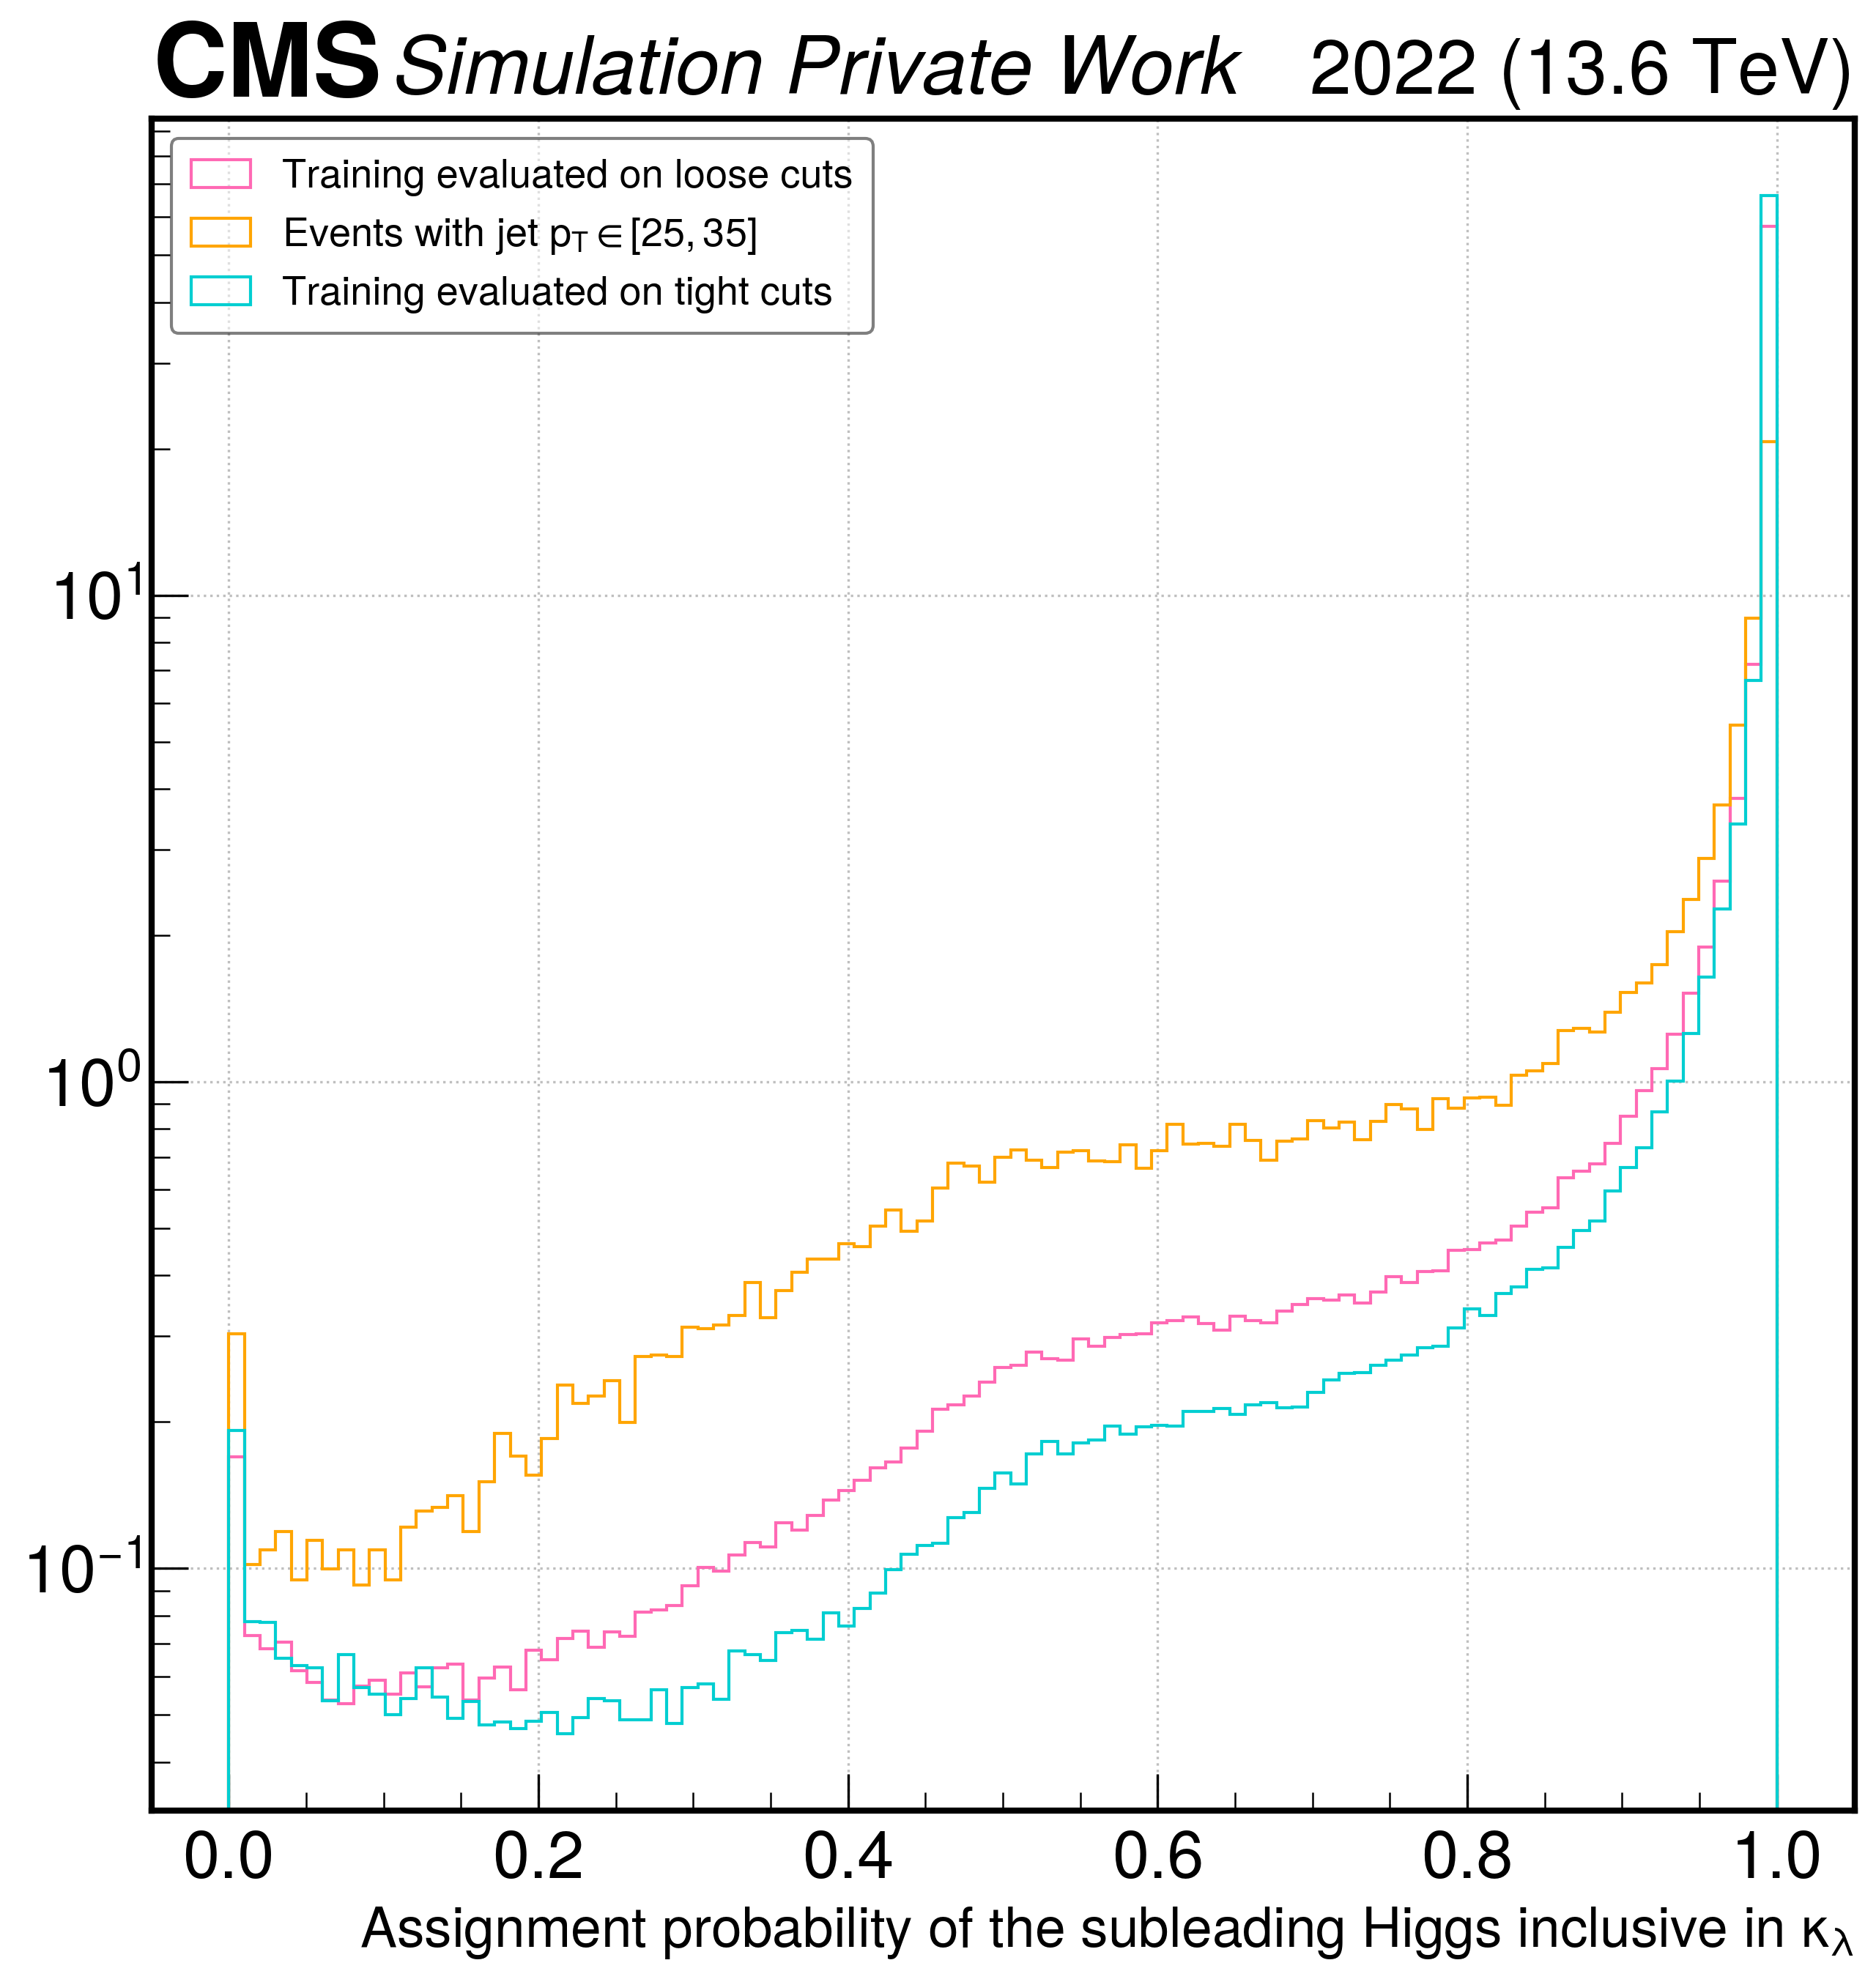

In [7]:
#Assigment porbability computed inclusively

def assigment_proba(dataset, label):
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    mask_pt_35=ak.any(presel[pt]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_pt_35]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=presel[pt][mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask ]< 35
    

    ass_proba_h1=dataset["TARGETS"]["h1"]["assignment_probability"][()]
    ass_proba_mask_h1=ass_proba_h1[mask_pt_35]
    ass_proba_h1_total_mask=ass_proba_mask_h1[mask_b1 | mask_b2]
    
    ass_proba_h2=dataset["TARGETS"]["h2"]["assignment_probability"][()]
    ass_proba_mask_h2=ass_proba_h2[mask_pt_35]
    ass_proba_h2_total_mask=ass_proba_mask_h2[mask_b3 | mask_b4]
    

    return ass_proba_h1_total_mask, ass_proba_h1, ass_proba_h2_total_mask, ass_proba_h2
    
ass_proba_mask_h1, ass_proba_h1, ass_proba_mask_h2,ass_proba_h2 =assigment_proba(df_pred_nc_on_nc, "Pred") 

print(ass_proba_h1)
print(ass_proba_h2)
    
print(len(ass_proba_h1))
print(len(ass_proba_h2))

#Plotting the assigment probability inclusive in kl

def plot_ass_proba():
    proba_mask_h1_kl_, proba_h1_kl_, proba_mask_h2_kl_, proba_h2_kl_=assigment_proba(df_pred_oc_on_nc, "Pred") 
    proba_mask_h1_kl_oc, proba_h1_kl_oc, proba_mask_h2_kl_oc, proba_h2_kl_oc=assigment_proba(df_pred_oc_on_oc, "Pred") 
    
    plt.figure()
    plt.hist(proba_h1_kl_, bins=np.linspace(0,1,100), histtype='step', color="hotpink", density="True", label="Training evaluated on loose cuts")
    plt.hist(proba_mask_h1_kl_, bins=np.linspace(0,1,100), histtype='step', color="orange",density="True", label= "Events with jet $p_T \in [25,35]$")
    plt.hist(proba_h1_kl_oc, bins=np.linspace(0,1,100), histtype='step', color="darkturquoise",density="True", label= "Training evaluated on tight cuts")
    plt.yscale("log")
    plt.legend(loc="upper left", prop = { "size": 13 }, frameon=True, fancybox=True, framealpha=0.5, edgecolor='black')
    plt.grid(linestyle=":")
    plt.tick_params(axis='both', which='both', bottom=True, left=True, top=False, right=False)
    plt.xlabel(f"Assignment probability of the leading Higgs inclusive in $\kappa_\lambda$", fontsize=18)
    hep.cms.label(
        year="2022",
        com="13.6",
        label=f"Private Work",
    )
    plt.show()
    
    plt.figure()
    plt.hist(proba_h2_kl_, bins=np.linspace(0,1,100), histtype='step', color="hotpink", density="True", label="Training evaluated on loose cuts")
    plt.hist(proba_mask_h2_kl_, bins=np.linspace(0,1,100), histtype='step', color="orange",density="True", label= "Events with jet $p_T \in [25,35]$")
    plt.hist(proba_h2_kl_oc, bins=np.linspace(0,1,100), histtype='step', color="darkturquoise",density="True", label= "Training evaluated on tight cuts")
    plt.yscale("log")
    plt.legend(loc="upper left", prop = { "size": 13 }, frameon=True, fancybox=True, framealpha=0.5, edgecolor='black')
    plt.tick_params(axis='both', which='both', bottom=True, left=True, top=False, right=False)
    plt.grid(linestyle=":")
    plt.xlabel(f"Assignment probability of the subleading Higgs inclusive in $\kappa_\lambda$", fontsize=18)    
    hep.cms.label(
        year="2022",
        com="13.6",
        label=f"Private Work",
    )
    plt.show()
    
plot_ass_proba()
    

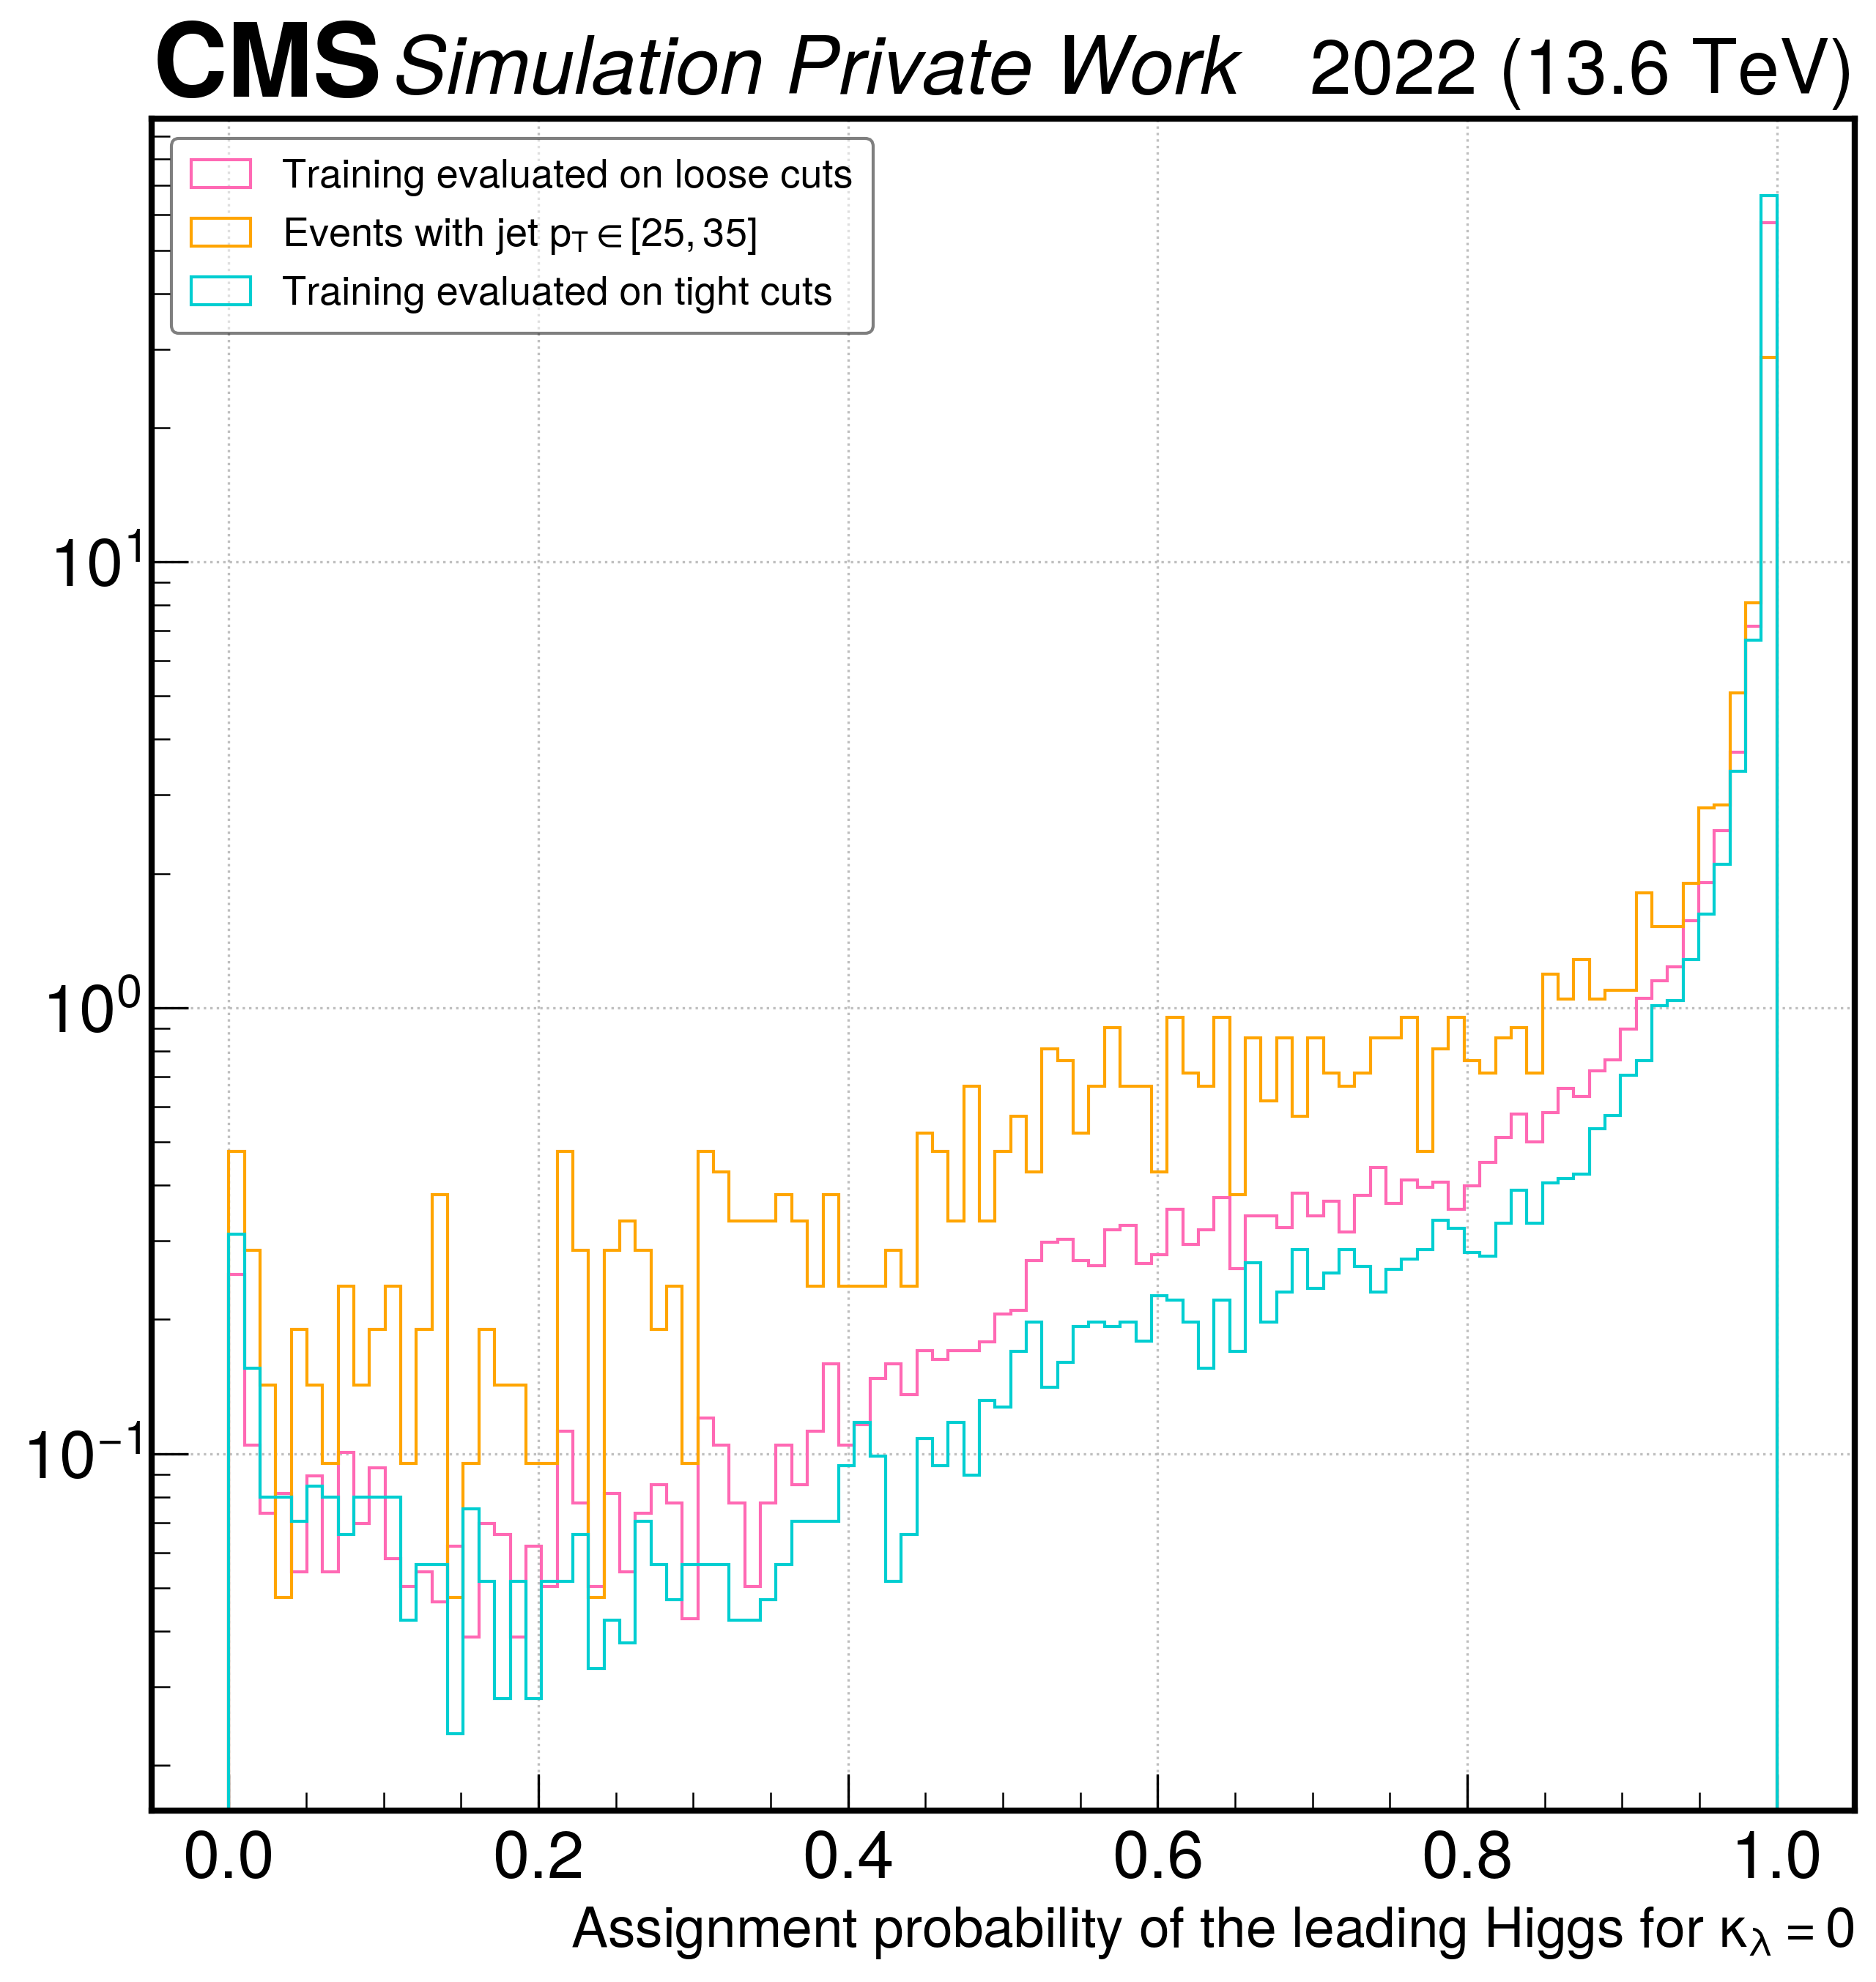

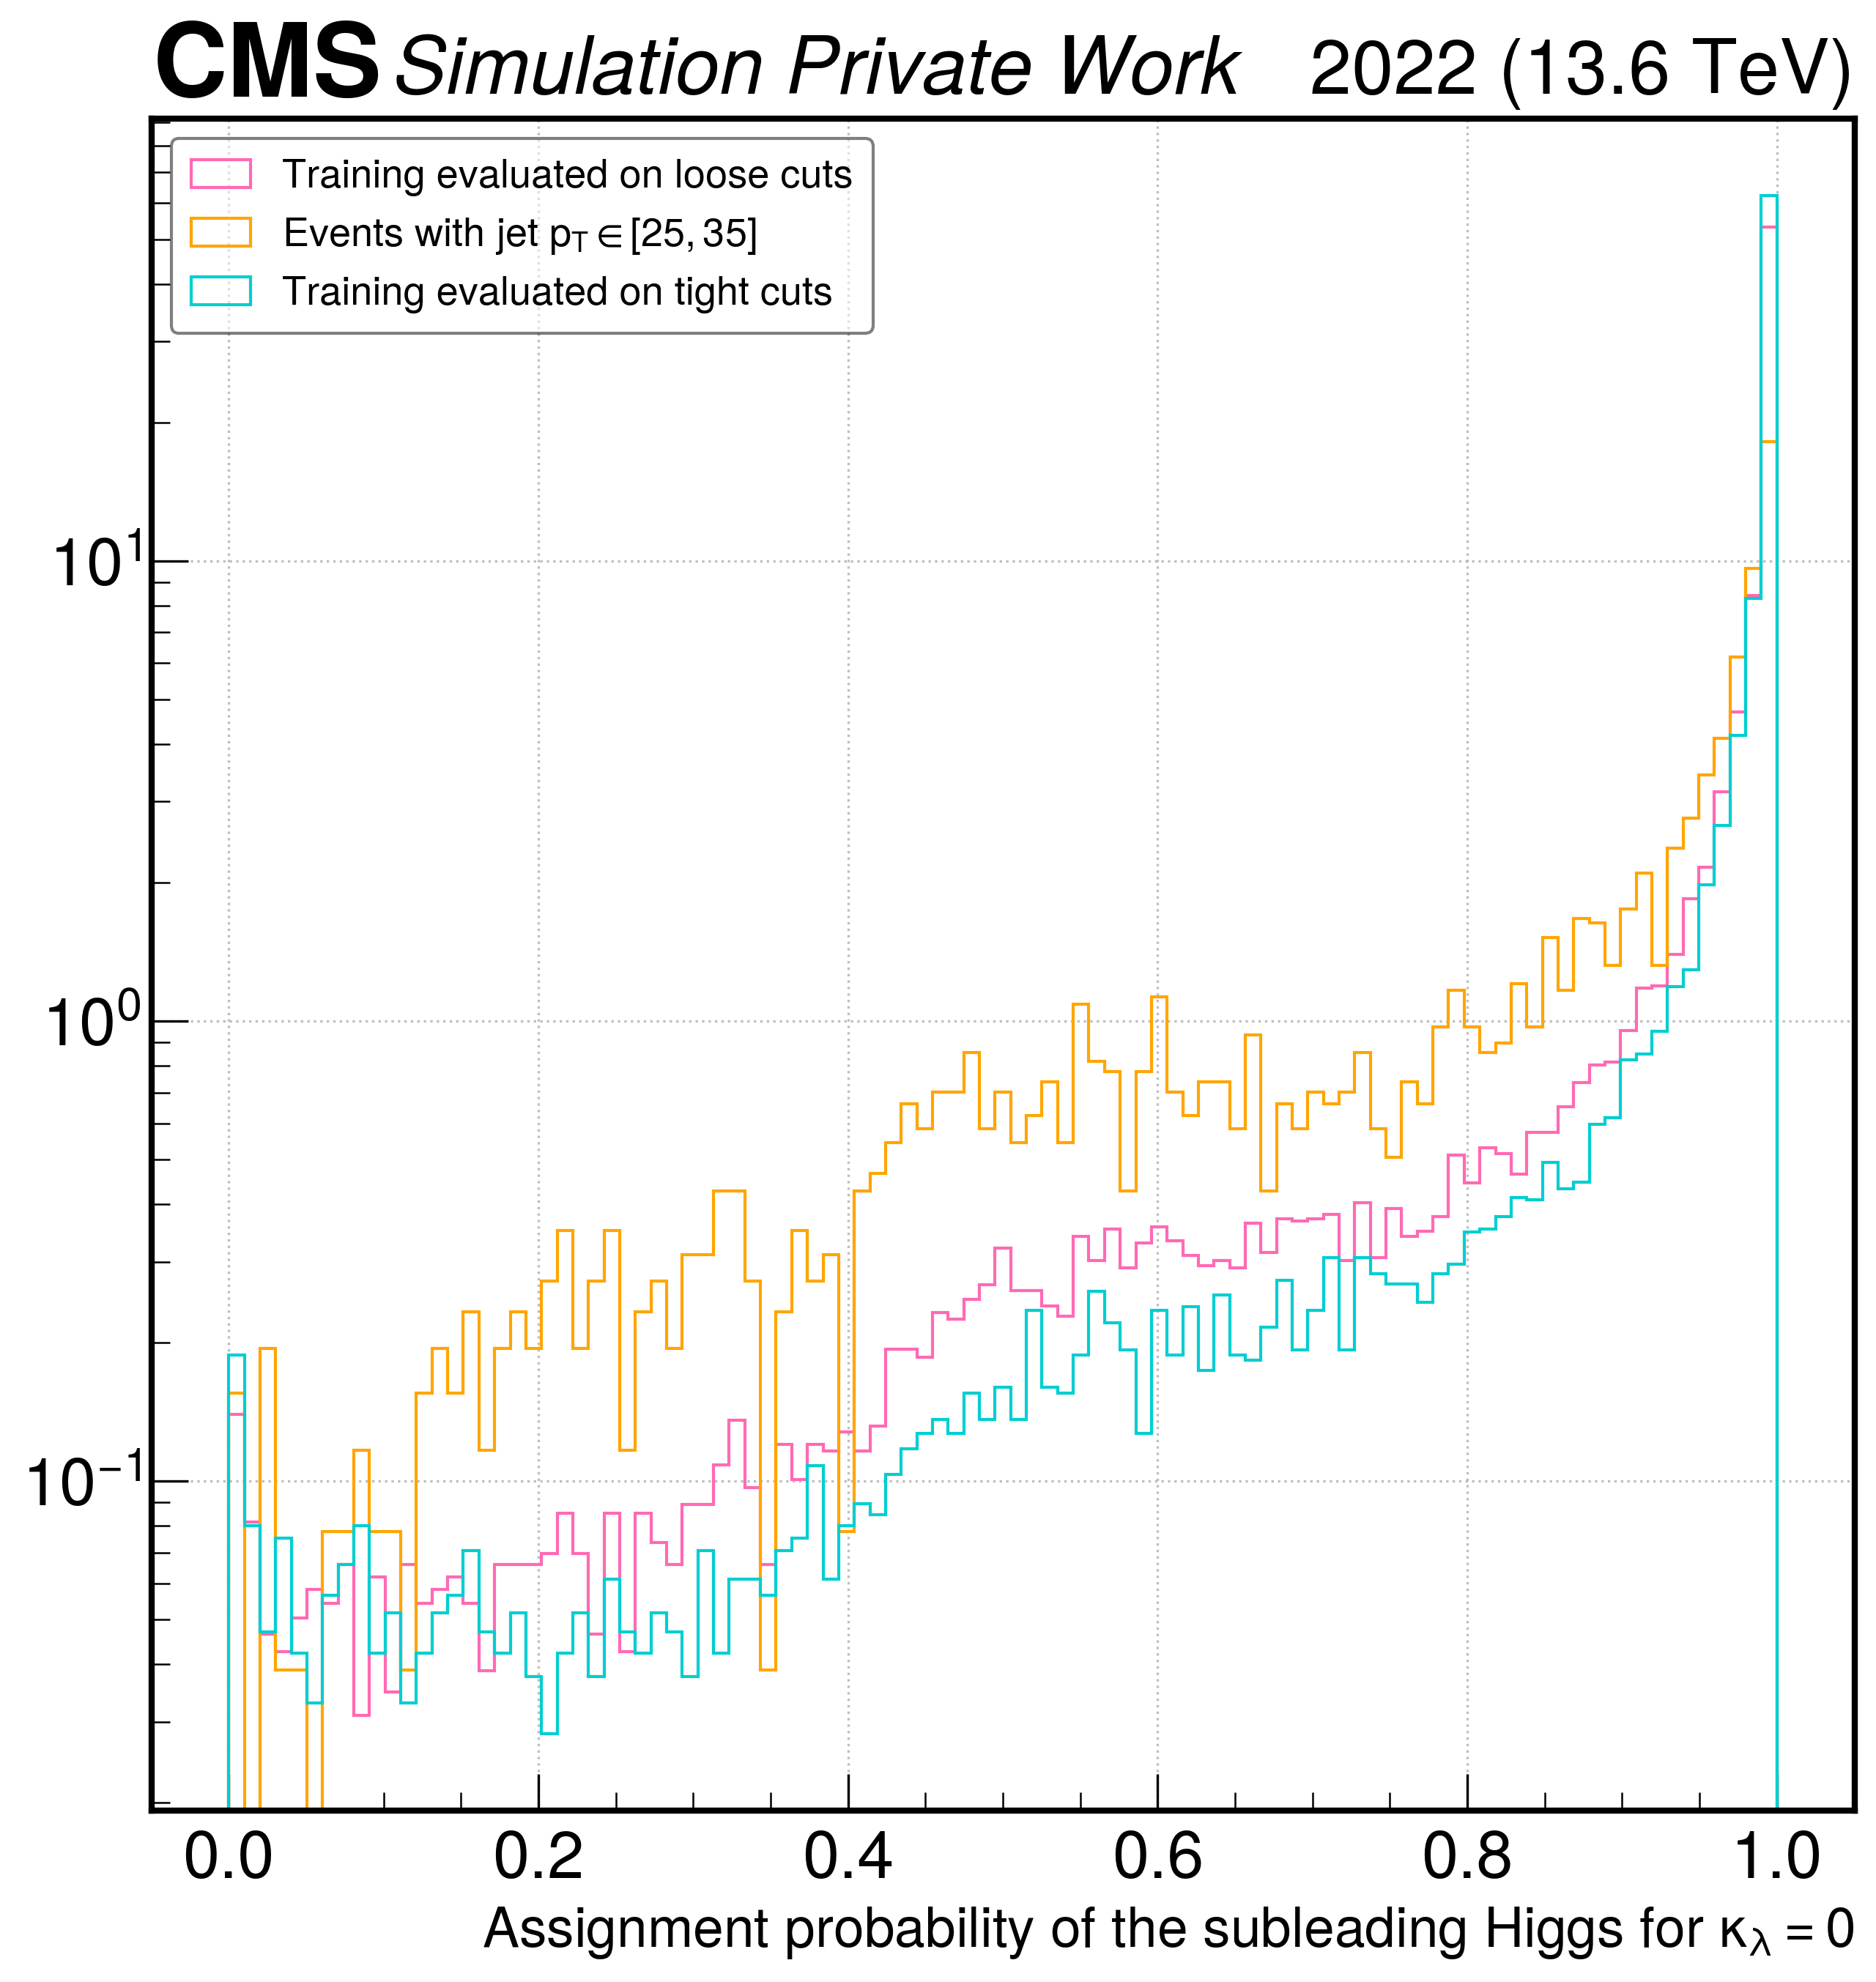

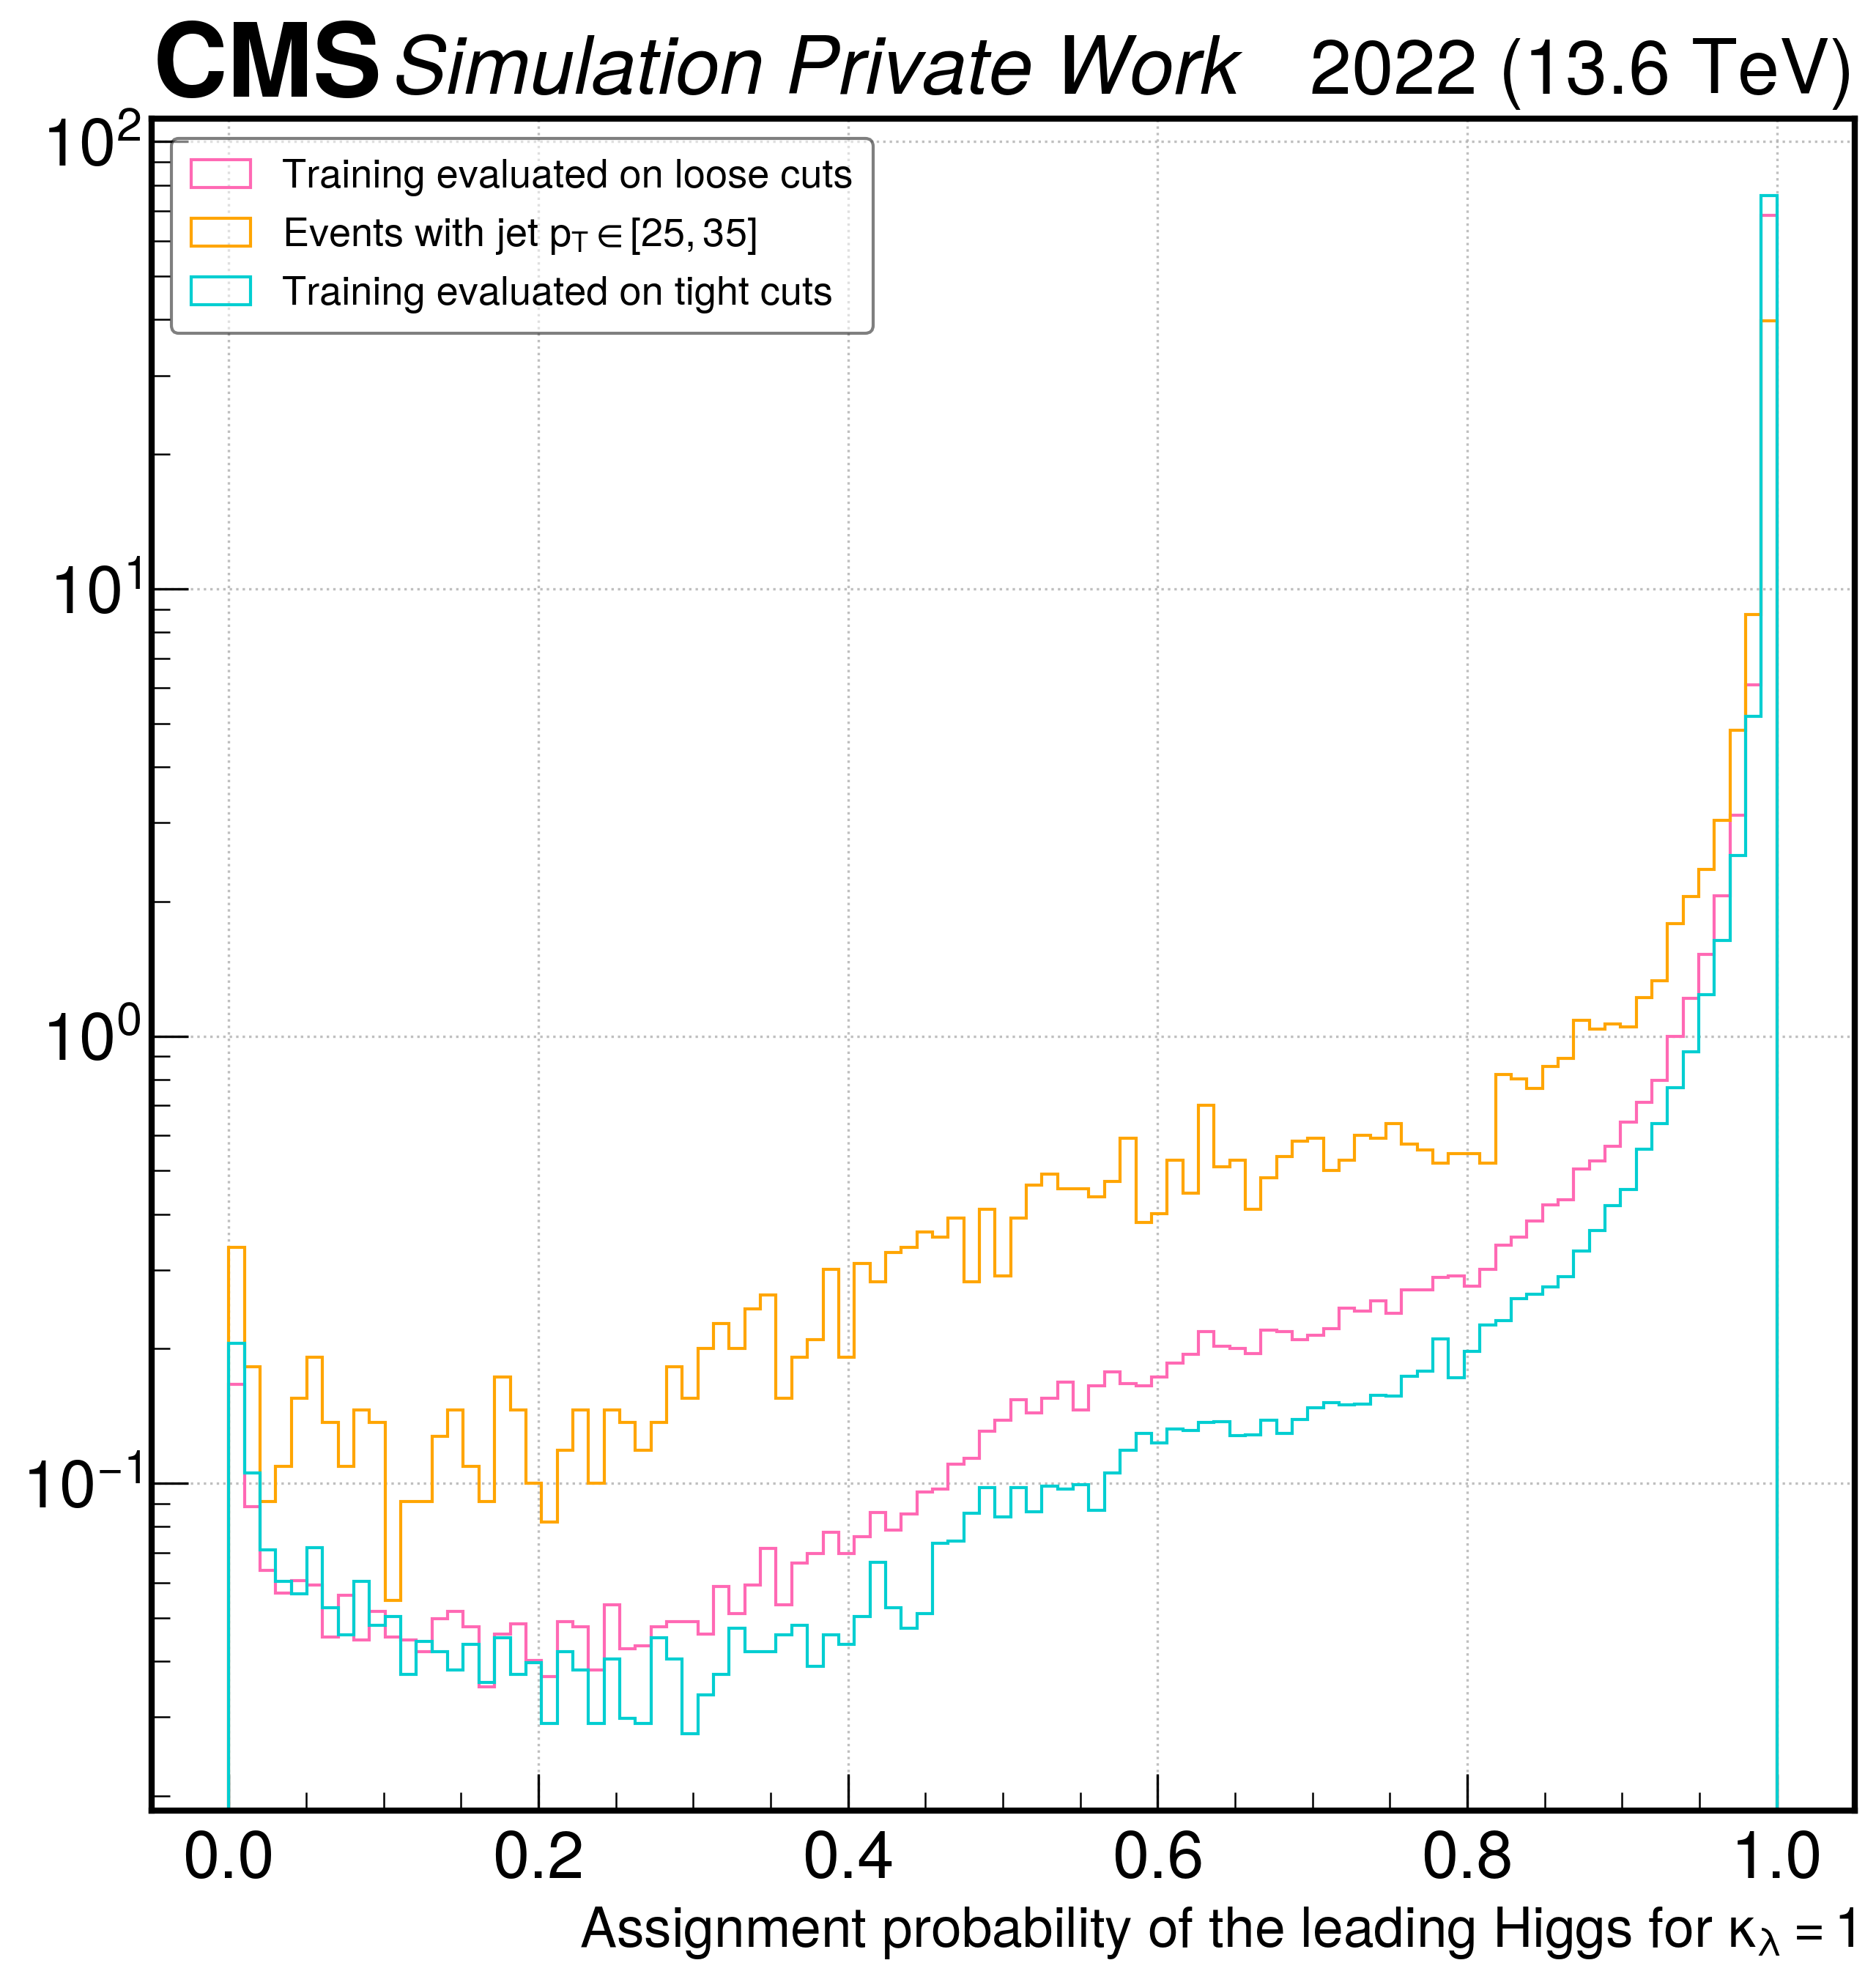

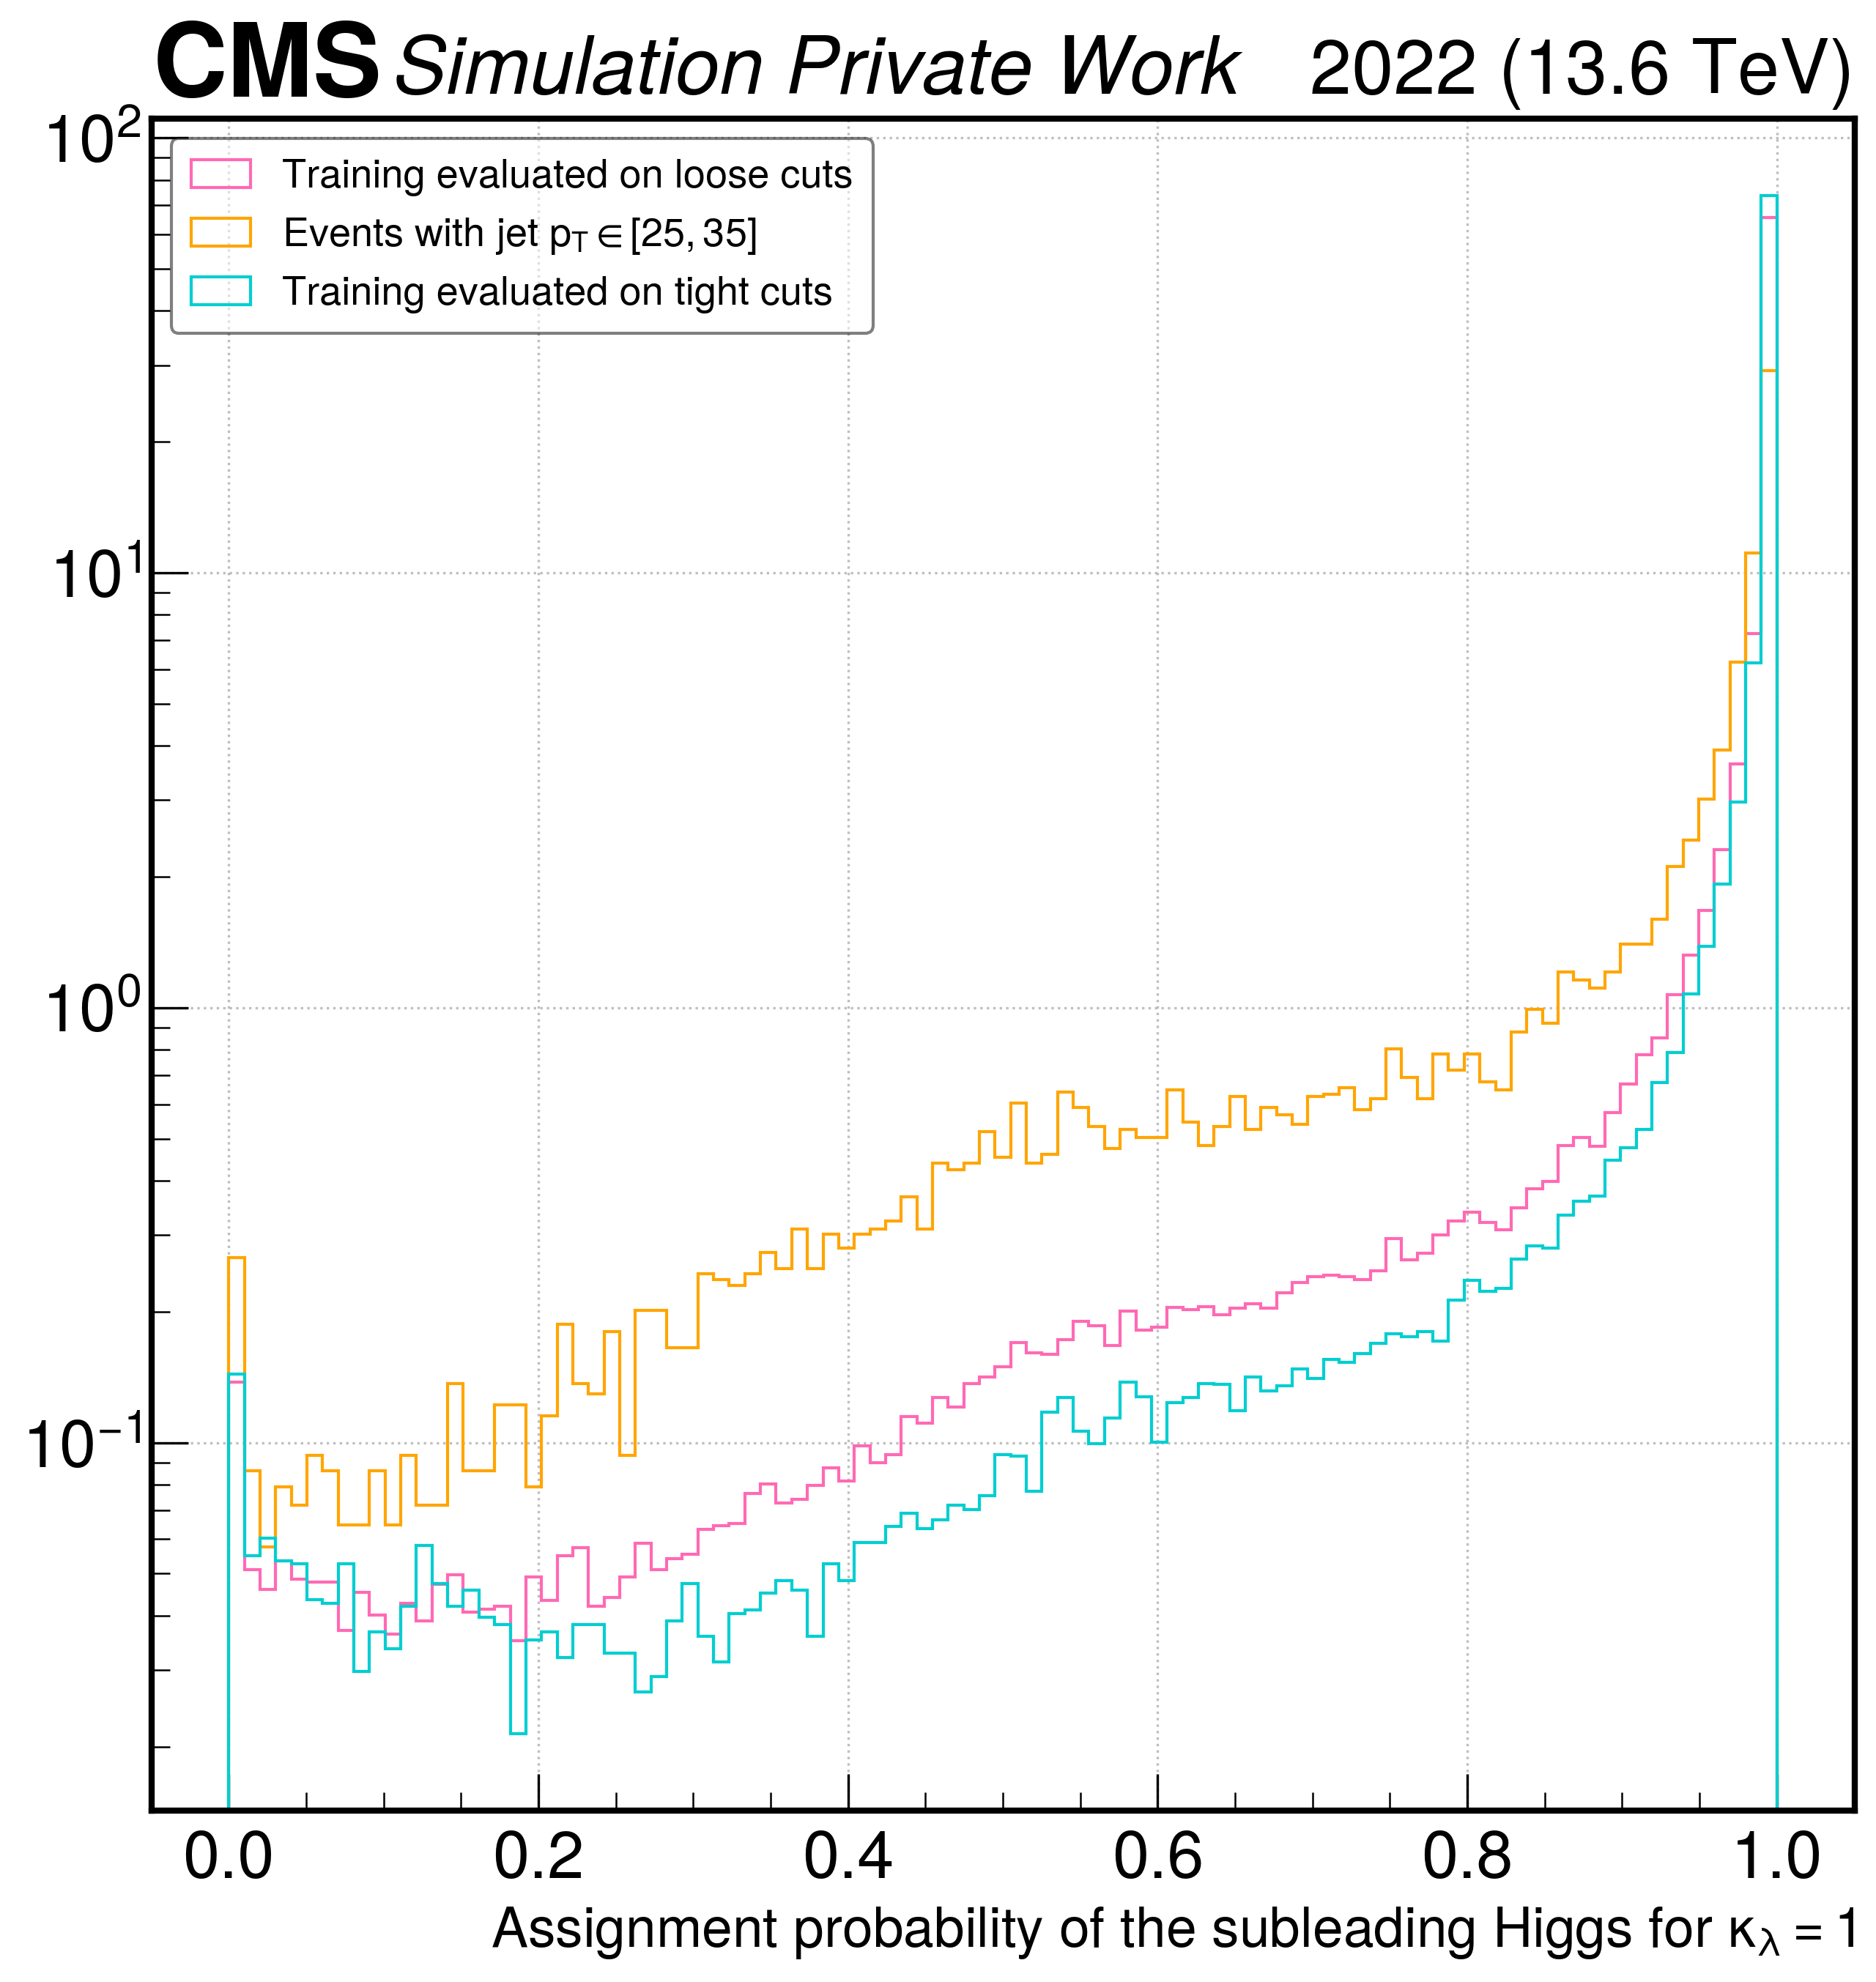

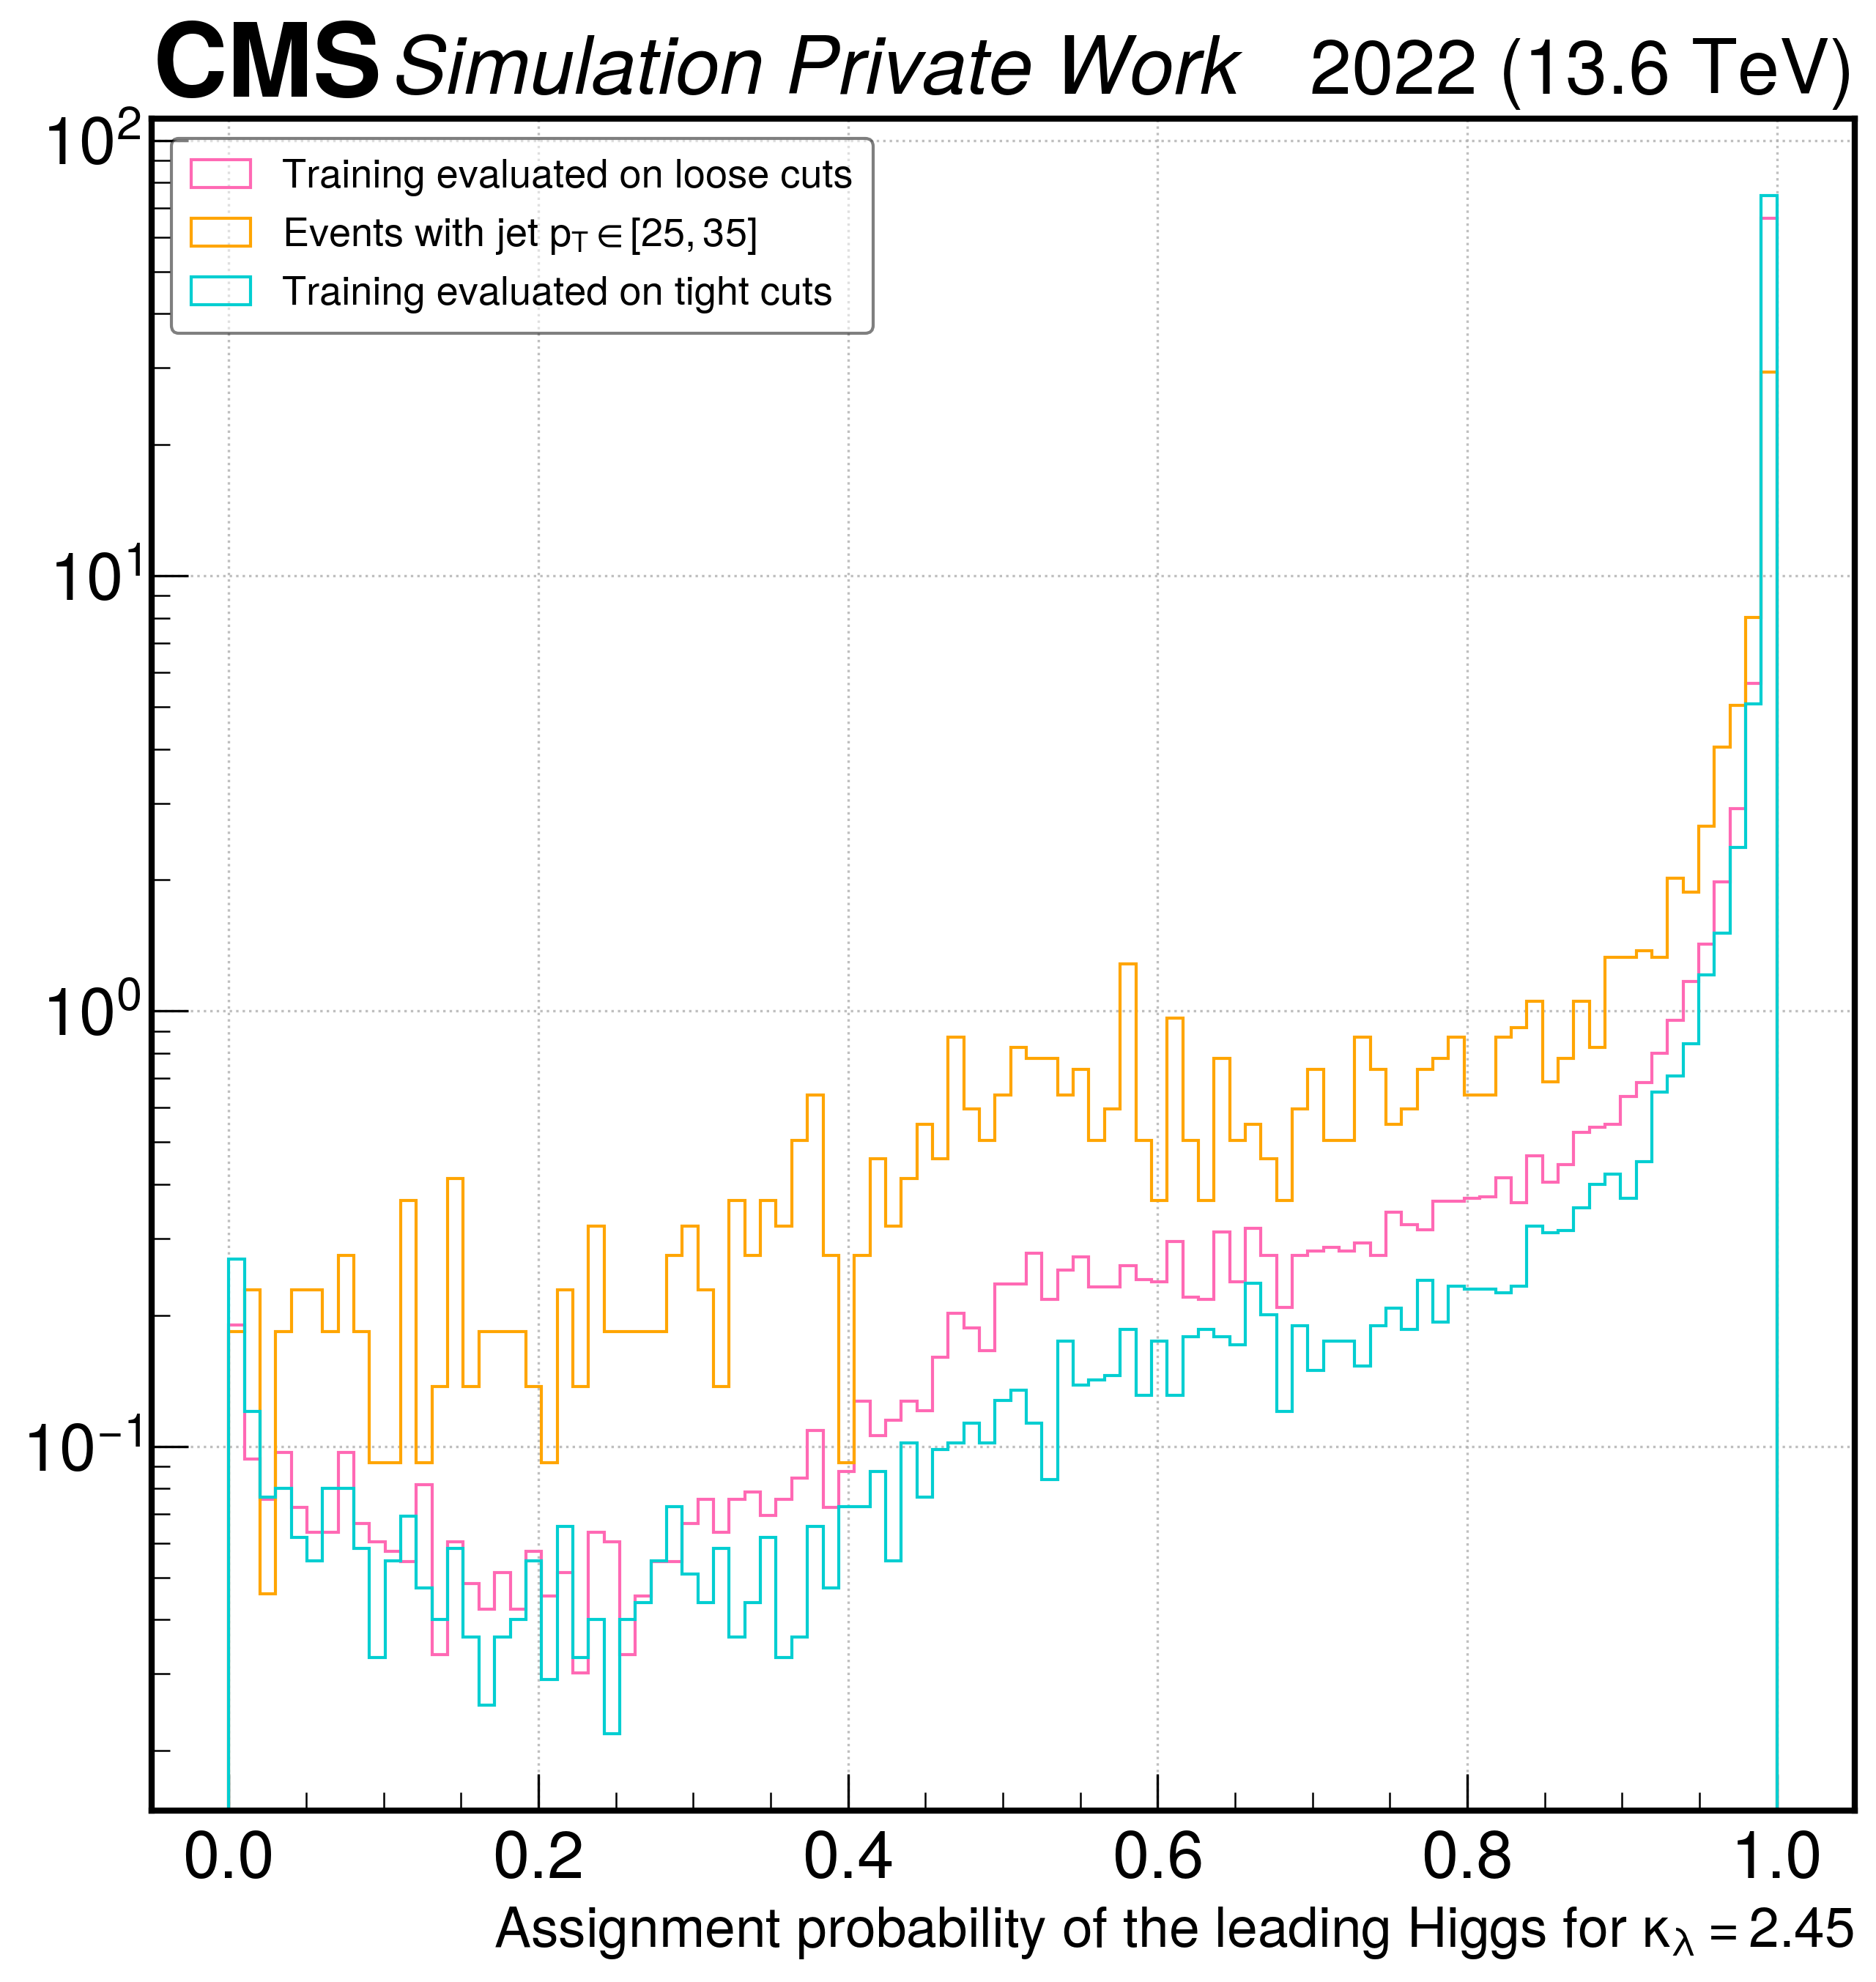

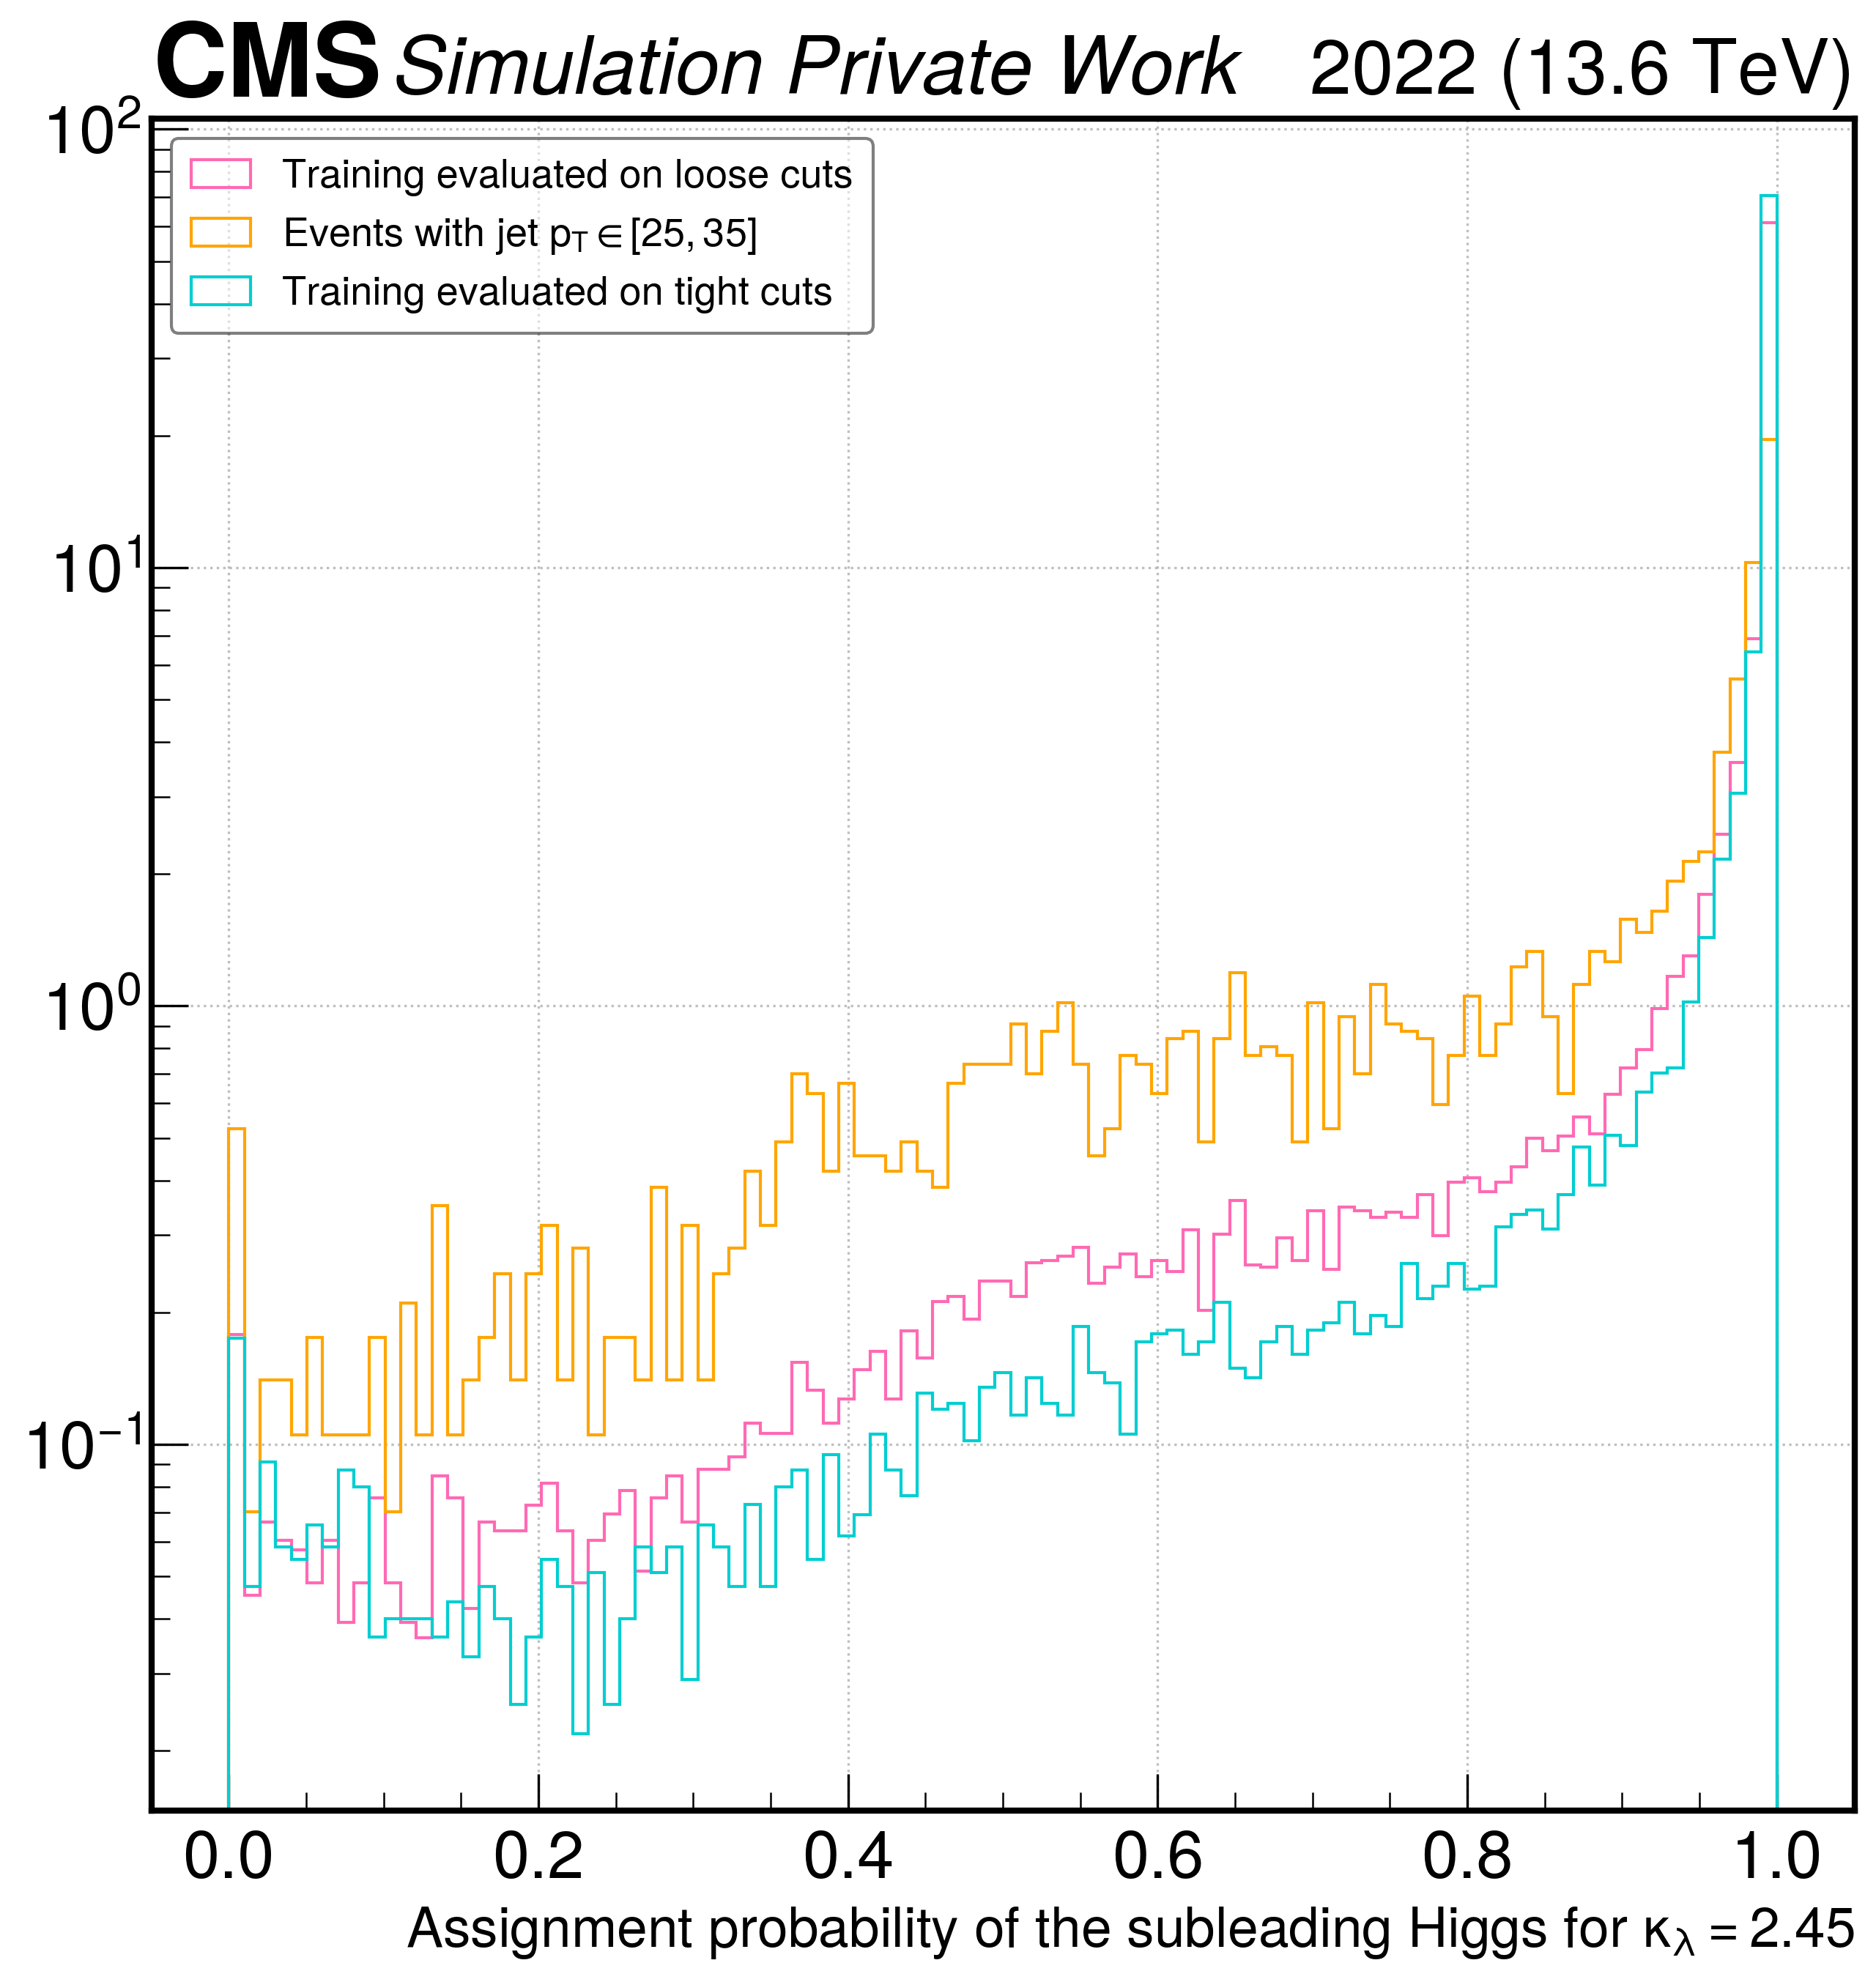

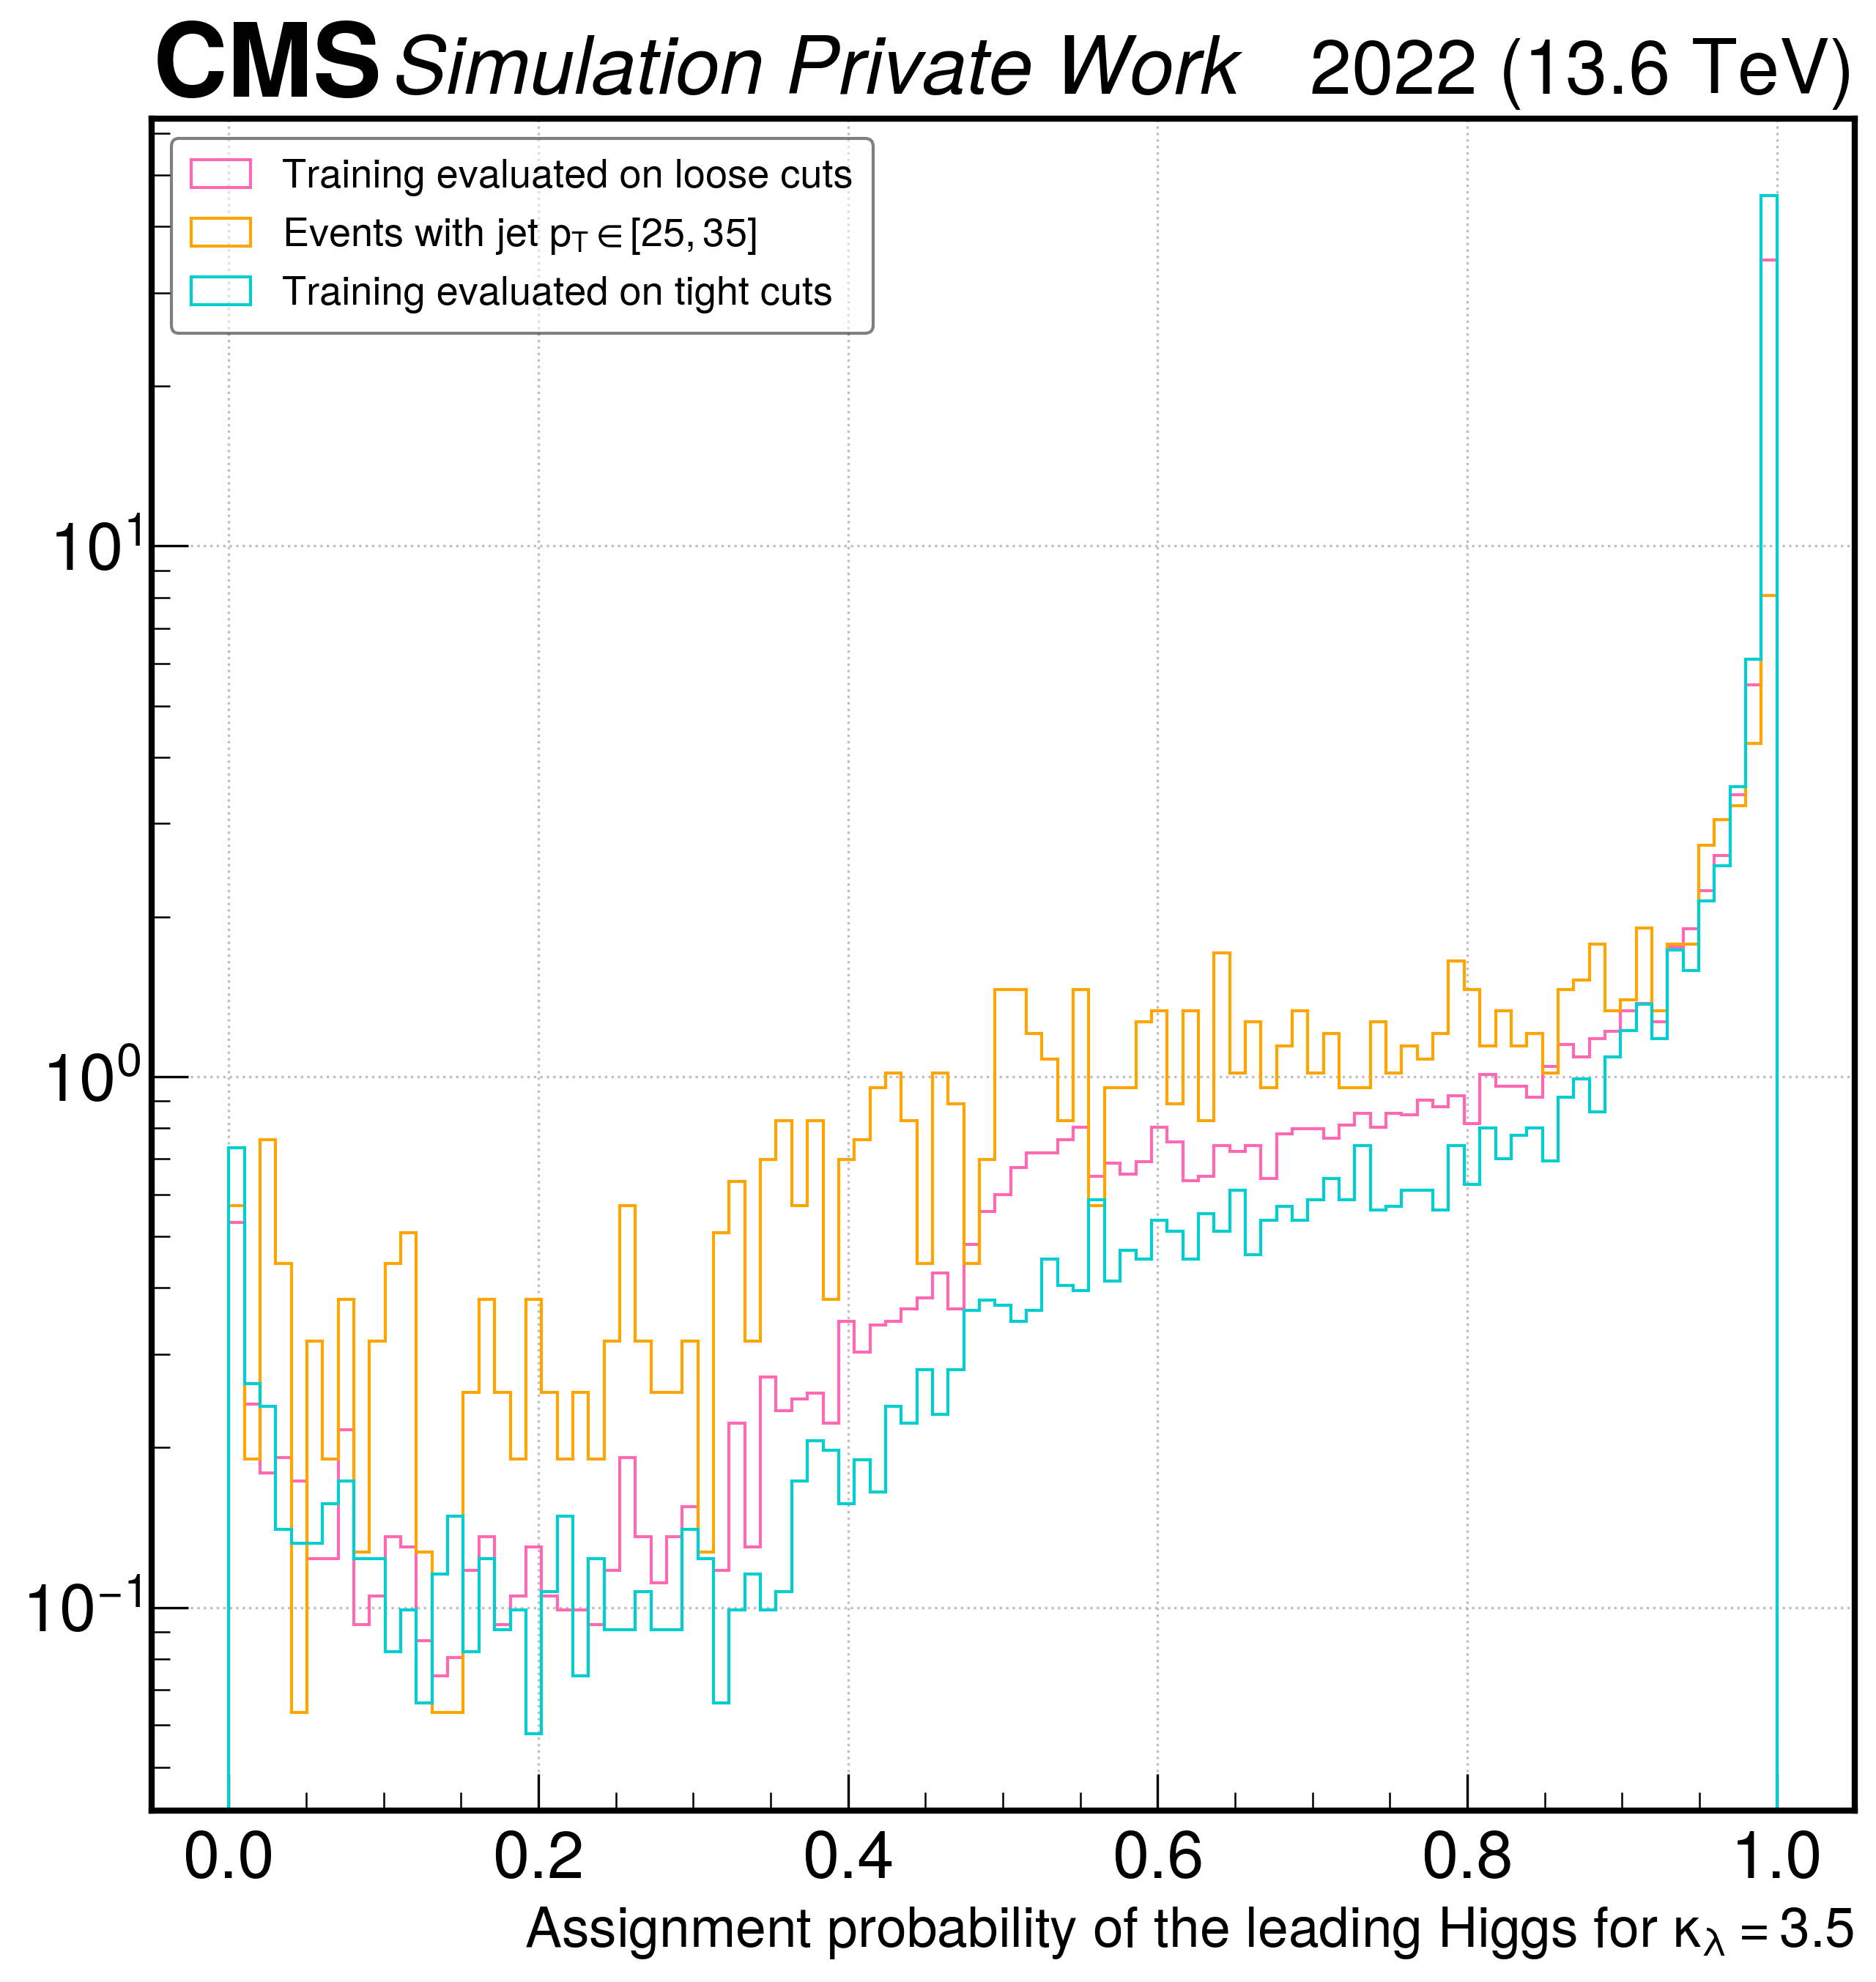

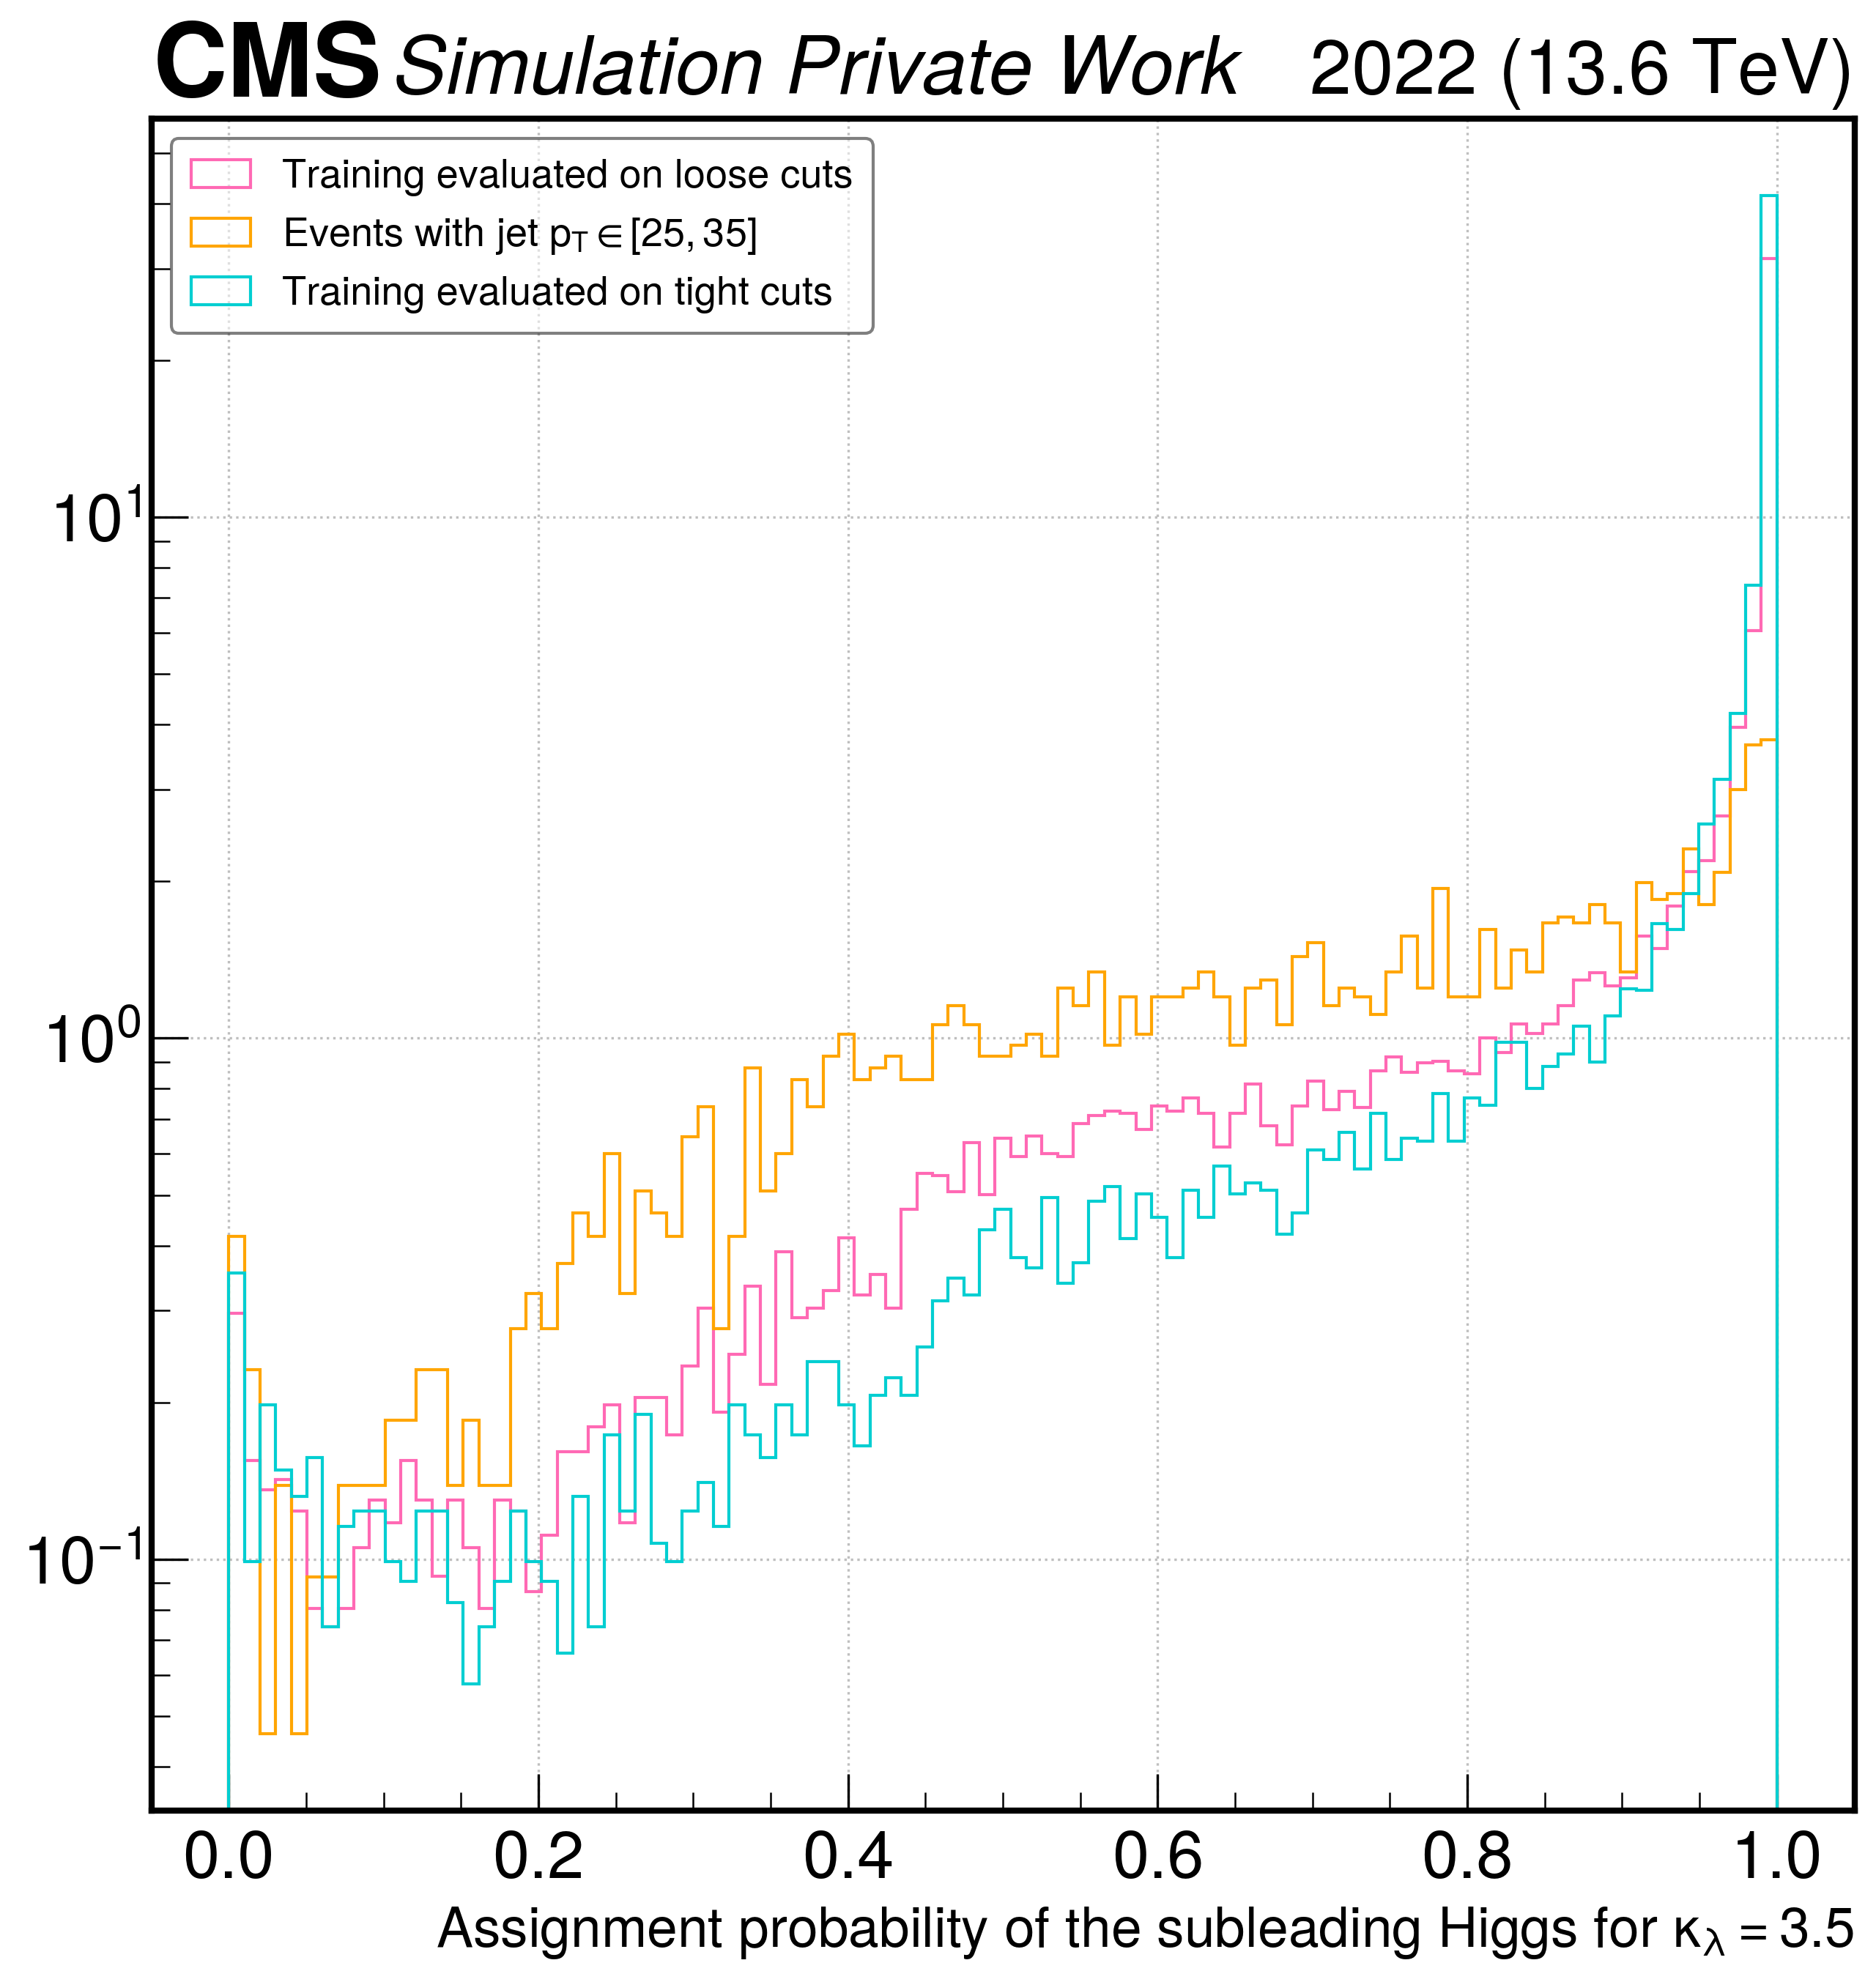

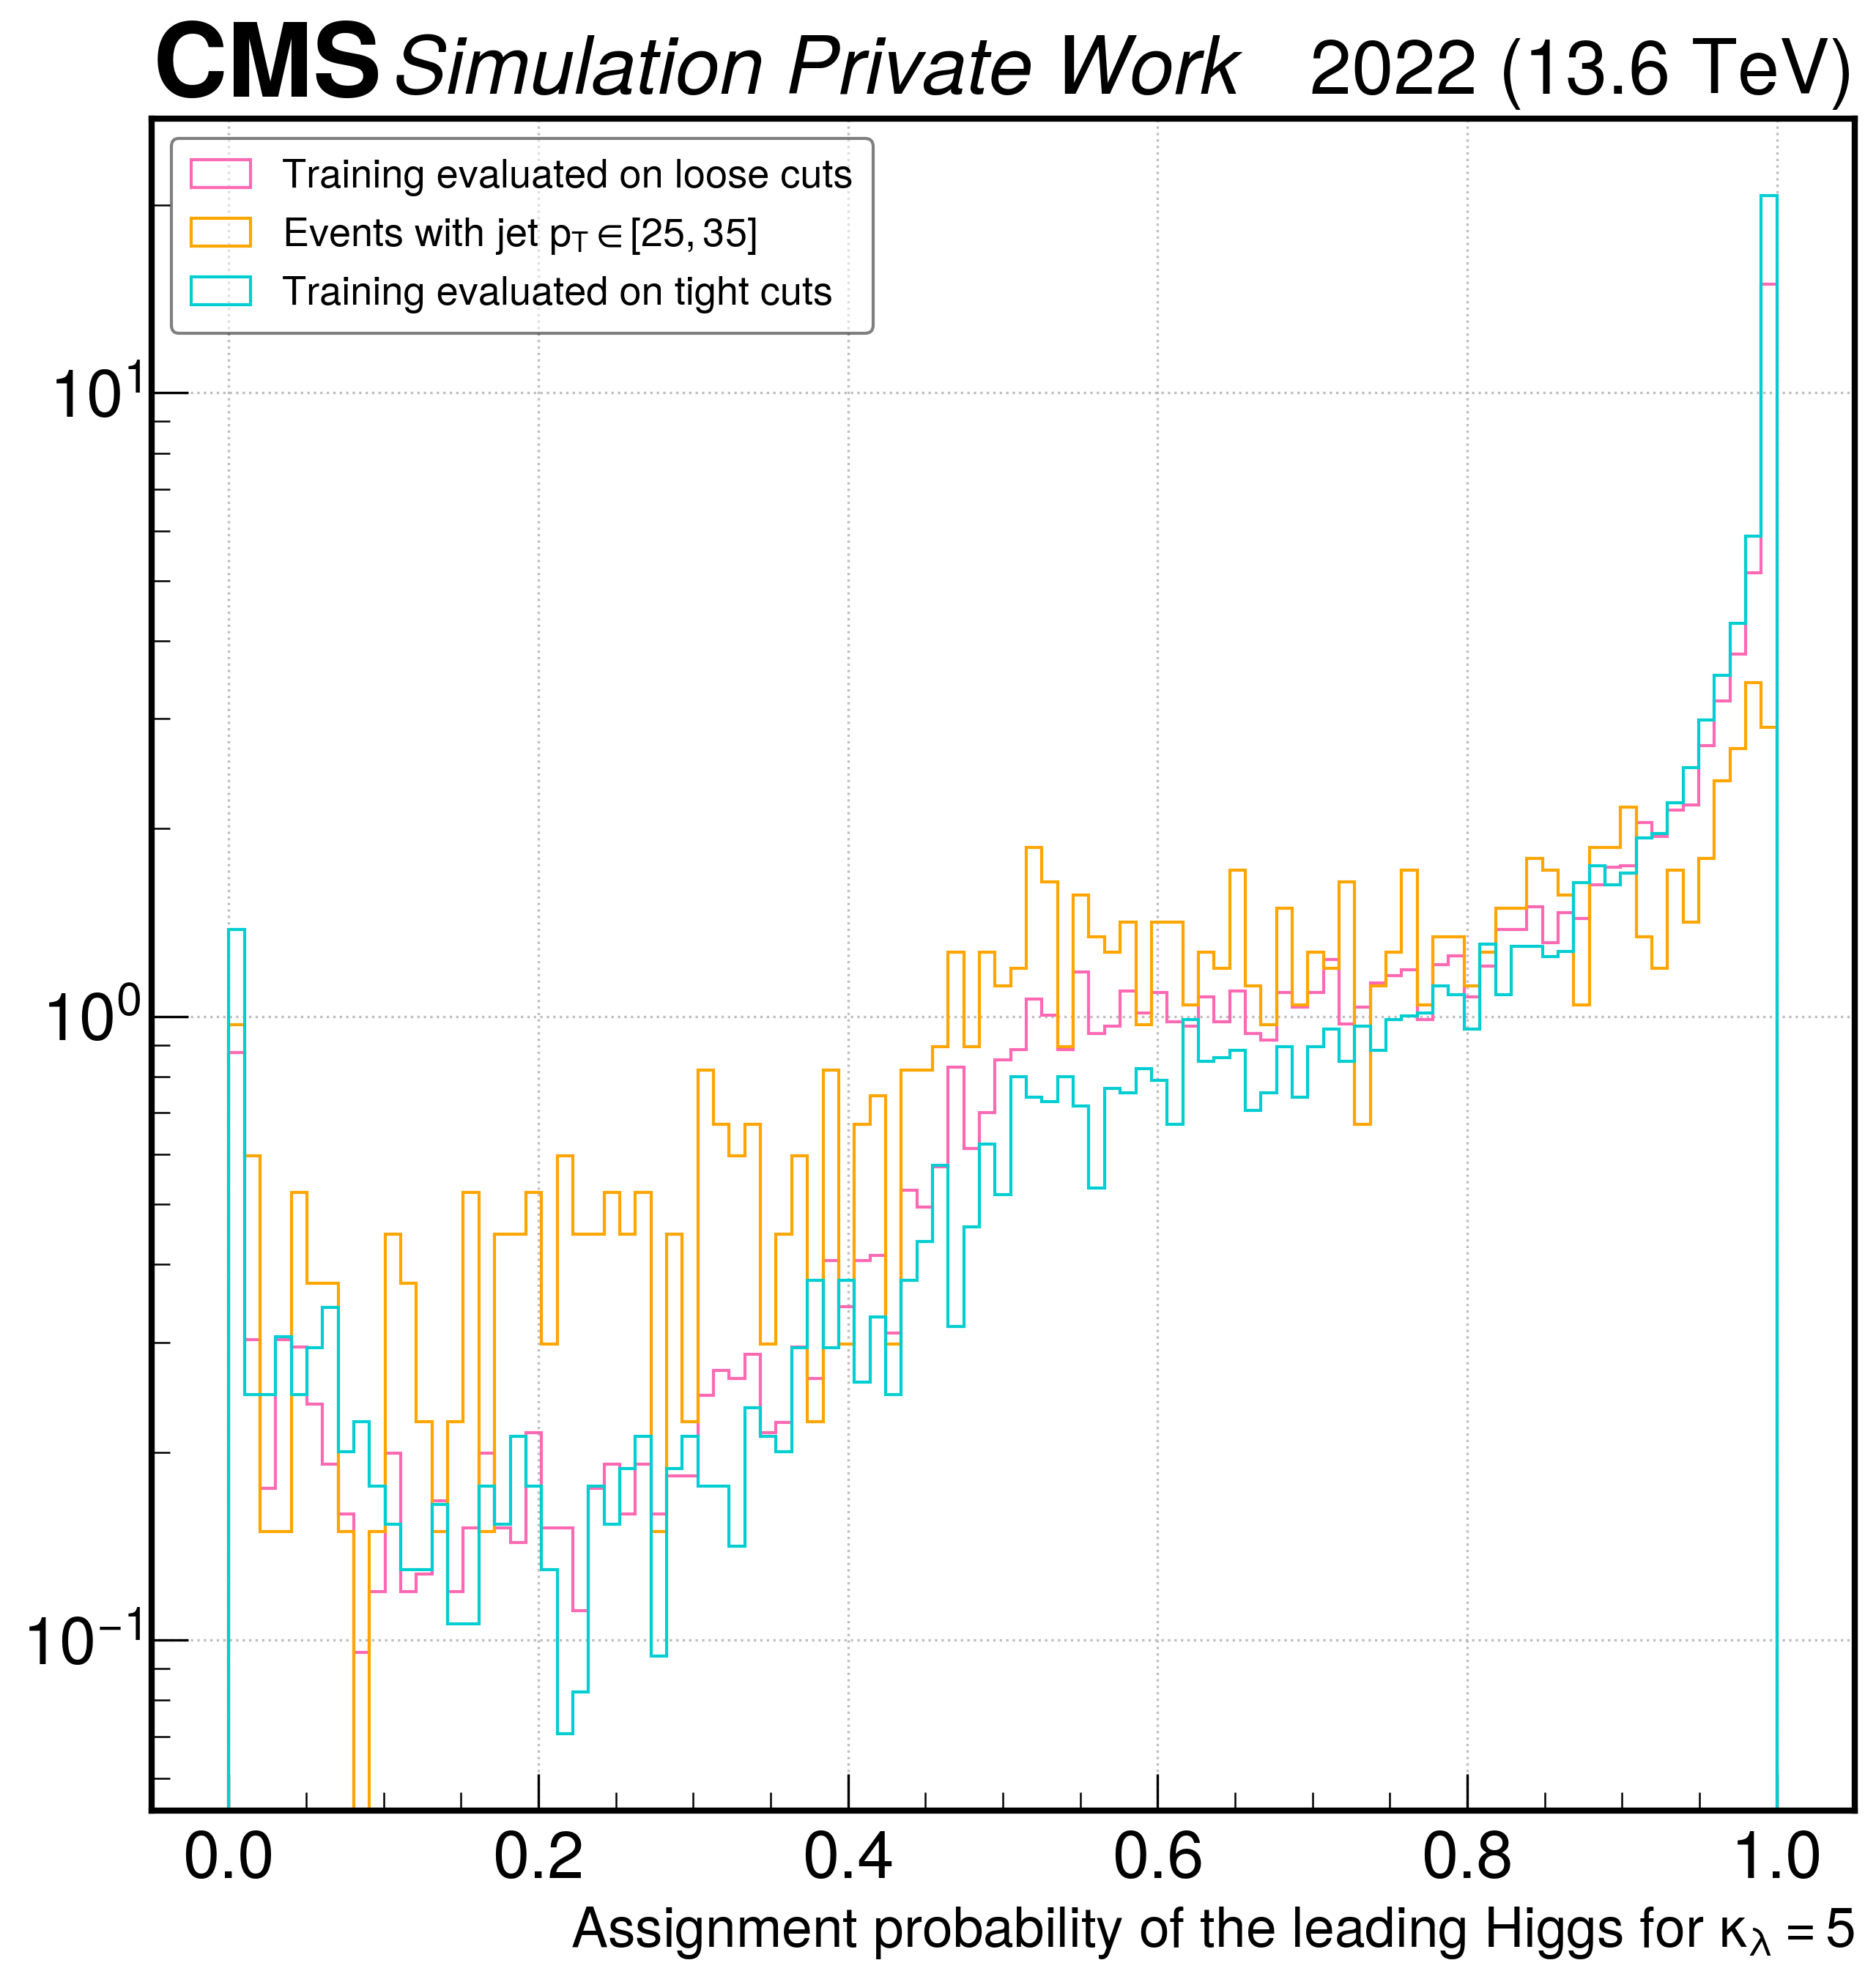

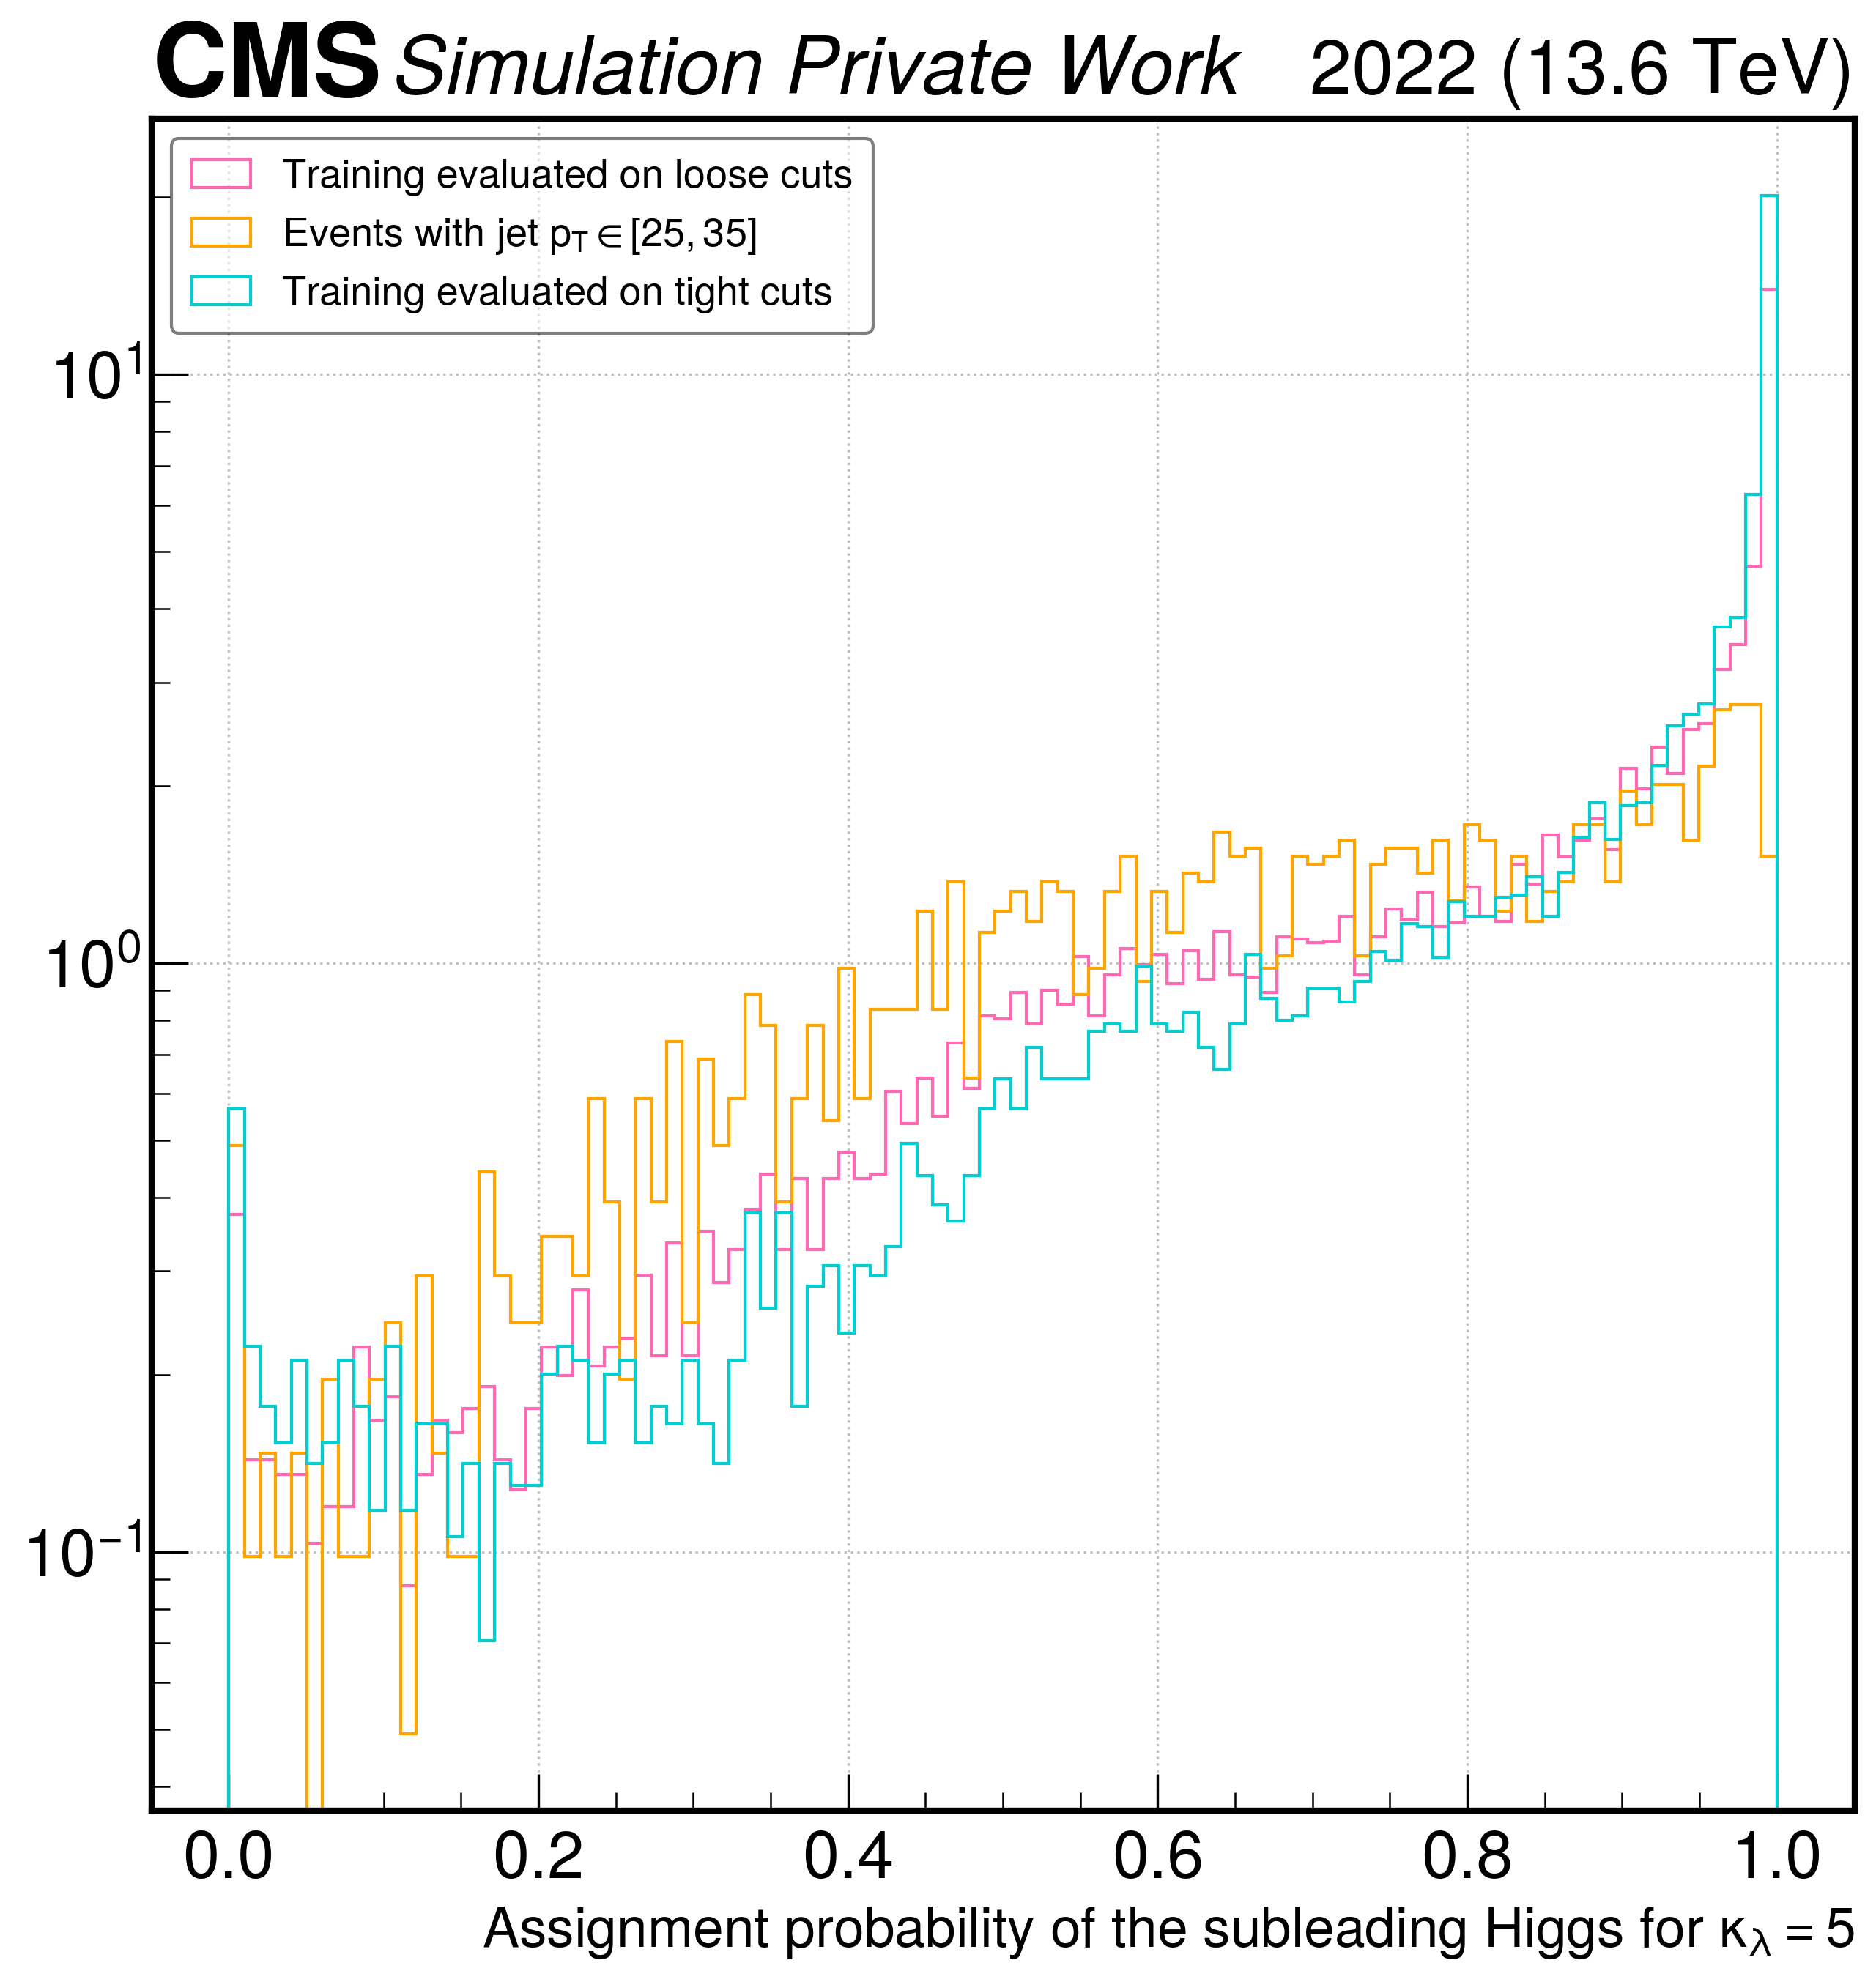

In [8]:
#Assignment probability computed differentially in kl
def assigment_proba_kl(dataset, label, kl):
    
    mask_kl=dataset['INPUTS']['Event']['kl'][()]==kl
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    pt_kl=presel[pt][mask_kl]
    # print("pt_kl",pt_kl)
    # print(len(pt_kl))
    mask_pt_35=ak.any(pt_kl<35,axis=1)
    # # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_kl][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_kl][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_kl][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_kl][mask_pt_35]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=pt_kl[mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask ]< 35
    

    ass_proba_h1=dataset["TARGETS"]["h1"]["assignment_probability"][()] 
    ass_proba_h1_kl=ass_proba_h1[mask_kl]
    # print(ass_proba_h1)
    ass_proba_mask_h1=ass_proba_h1_kl[mask_pt_35]
    ass_proba_h1_total_mask=ass_proba_mask_h1[mask_b1 | mask_b2]
    
    ass_proba_h2=dataset["TARGETS"]["h2"]["assignment_probability"][()]
    ass_proba_h2_kl=ass_proba_h2[mask_kl]
    ass_proba_mask_h2=ass_proba_h2_kl[mask_pt_35]
    ass_proba_h2_total_mask=ass_proba_mask_h2[mask_b3 | mask_b4]
    

    return ass_proba_h1_kl, ass_proba_h1_total_mask,ass_proba_h2_kl, ass_proba_h2_total_mask

kl=[0,1,2.45,3.5,5]


def plot_ass_proba(kl):
    proba_h1_kl_,proba_mask_h1_kl_, proba_h2_kl_, proba_mask_h2_kl_=assigment_proba_kl(df_pred_oc_on_nc, "Pred", kl) 
    proba_h1_kl_oc,proba_mask_h1_kl_oc, proba_h2_kl_oc, proba_mask_h2_kl_oc=assigment_proba_kl(df_pred_oc_on_oc, "Pred", kl) 
    
    plt.figure()
    plt.hist(proba_h1_kl_, bins=np.linspace(0,1,100), histtype='step', color="hotpink", density="True", label="Training evaluated on loose cuts")
    plt.hist(proba_mask_h1_kl_, bins=np.linspace(0,1,100), histtype='step', color="orange",density="True", label= "Events with jet $p_T \in [25,35]$")
    plt.hist(proba_h1_kl_oc, bins=np.linspace(0,1,100), histtype='step', color="darkturquoise",density="True", label= "Training evaluated on tight cuts")
    plt.yscale("log")
    plt.legend(loc="upper left", prop = { "size": 13 }, frameon=True, fancybox=True, framealpha=0.5, edgecolor='black')
    plt.grid(linestyle=":")
    plt.tick_params(axis='both', which='both', bottom=True, left=True, top=False, right=False)
    plt.xlabel(f"Assignment probability of the leading Higgs for $\kappa_\lambda=${kl}", fontsize=18)
    hep.cms.label(
        year="2022",
        com="13.6",
        label=f"Private Work",
    )
    plt.show()
    
    plt.figure()
    plt.hist(proba_h2_kl_, bins=np.linspace(0,1,100), histtype='step', color="hotpink", density="True", label="Training evaluated on loose cuts")
    plt.hist(proba_mask_h2_kl_, bins=np.linspace(0,1,100), histtype='step', color="orange",density="True", label= "Events with jet $p_T \in [25,35]$")
    plt.hist(proba_h2_kl_oc, bins=np.linspace(0,1,100), histtype='step', color="darkturquoise",density="True", label= "Training evaluated on tight cuts")
    plt.yscale("log")
    plt.legend(loc="upper left", prop = { "size": 13 }, frameon=True, fancybox=True, framealpha=0.5, edgecolor='black')
    plt.tick_params(axis='both', which='both', bottom=True, left=True, top=False, right=False)
    plt.grid(linestyle=":")
    plt.xlabel(f"Assignment probability of the subleading Higgs for $\kappa_\lambda=${kl}", fontsize=18)    
    hep.cms.label(
        year="2022",
        com="13.6",
        label=f"Private Work",
    )
    plt.show()

for k in kl:
    plot_ass_proba(k)

# ass_proba_h1_kl1=assigment_proba_kl(df_pred_nc, "Pred", 1) 

In [9]:
#Computing the efficiencies differencialy in kl
#Function to compute HH with at least on of the H reconstructed having a jet with pt < 35 GeV

def mask_35_h_on_pred_kl(dataset, dataset_pred,label, label_pred,kl):
    
    mask_kl=dataset['INPUTS']['Event']['kl'][()]==kl
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    pt_kl=presel[pt][mask_kl]
    mask_pt_35=ak.any(pt_kl<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_kl][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_kl][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_kl][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_kl][mask_pt_35]
    
    presel_pred=preselection(dataset_pred, label_pred)
    pt_pred= filter_dataset(presel_pred, "pt")
    pt_kl_pred=presel_pred[pt_pred][mask_kl]
    mask_pt_35_pred=ak.any(pt_kl_pred<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask_pred= presel_pred[filter_dataset(presel_pred, "b1")][mask_kl][mask_pt_35_pred]
    idx_b2_mask_pred= presel_pred[filter_dataset(presel_pred, "b2")][mask_kl][mask_pt_35_pred]
    idx_b3_mask_pred= presel_pred[filter_dataset(presel_pred, "b3")][mask_kl][mask_pt_35_pred]
    idx_b4_mask_pred= presel_pred[filter_dataset(presel_pred, "b4")][mask_kl][mask_pt_35_pred]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=pt_kl_pred[mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask_pred ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask_pred ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask_pred ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask_pred ]< 35
    
    idx_b1_35= idx_b1_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b2_35= idx_b2_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b3_35= idx_b3_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b4_35= idx_b4_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    
    # print(len(idx_b1_35))
    
    idx_h1= ak.concatenate((ak.unflatten(idx_b1_35, ak.ones_like(idx_b1_35)), ak.unflatten(idx_b2_35, ak.ones_like(idx_b2_35))), axis=1)
    idx_h2= ak.concatenate((ak.unflatten(idx_b3_35, ak.ones_like(idx_b3_35)), ak.unflatten(idx_b4_35, ak.ones_like(idx_b4_35))), axis=1)
    idx_h= ak.concatenate((ak.unflatten(idx_h1, ak.ones_like(idx_h1[:,0])), ak.unflatten(idx_h2, ak.ones_like(idx_h2[:,0]))), axis=1)
    
    return idx_h


idx_nc_nc_pred_h =mask_35_h_on_pred_kl(df_pred_nc_on_nc, df_pred_nc_on_nc, "pred_nc", "pred_nc",1)
idx_nc_nc_true_h=mask_35_h_on_pred_kl(df_true_nc, df_pred_nc_on_nc,"true_nc", "pred_nc",1)

In [10]:
#Computing the efficiency

for k in kl:  
    idx_nc_nc_pred_h =mask_35_h_on_pred_kl(df_pred_nc_on_nc, df_pred_nc_on_nc, "pred_nc", "pred_nc",k)
    idx_nc_nc_true_h=mask_35_h_on_pred_kl(df_true_nc, df_pred_nc_on_nc,"true_nc", "pred_nc",k)
    
    correctly_fully_matched = (
        ak.all(
            idx_nc_nc_true_h[:, 0] == idx_nc_nc_pred_h[:, 0],
            axis=1,
        )
        | ak.all(
            idx_nc_nc_true_h[:, 0] ==idx_nc_nc_pred_h[:, 1],
            axis=1,
        )
        | ak.all(
            idx_nc_nc_true_h[:, 1] == idx_nc_nc_pred_h[:, 0],
            axis=1,
        )
        | ak.all(
           idx_nc_nc_true_h[:, 1] == idx_nc_nc_pred_h[:, 1],
            axis=1,
        )
    )
    
    print(f"Efficiency for training new cuts on new cuts for kl{k}",ak.sum(correctly_fully_matched) / len(idx_nc_nc_true_h))

    idx_oc_nc_true_h=mask_35_h_on_pred_kl(df_true_nc, df_pred_oc_on_nc,"true_nc", "pred_oc_nc",k)
    idx_oc_nc_pred_h =mask_35_h_on_pred_kl(df_pred_oc_on_nc, df_pred_oc_on_nc, "pred_oc_nc", "pred_oc_nc",k)
    
    correctly_fully_matched = (
        ak.all(
            idx_oc_nc_true_h[:, 0] == idx_oc_nc_pred_h[:, 0],
            axis=1,
        )
        | ak.all(
            idx_oc_nc_true_h[:, 0] ==idx_oc_nc_pred_h[:, 1],
            axis=1,
        )
        | ak.all(
            idx_oc_nc_true_h[:, 1] == idx_oc_nc_pred_h[:, 0],
            axis=1,
        )
        | ak.all(
           idx_oc_nc_true_h[:, 1] == idx_oc_nc_pred_h[:, 1],
            axis=1,
        )
    )
    
    print(f"Efficiency for training old cuts on new cuts for kl{k}",ak.sum(correctly_fully_matched) / len(idx_oc_nc_true_h))
    

    idx_oc_oc_pred_h =mask_35_h_on_pred_kl(df_pred_oc_on_oc, df_pred_oc_on_oc, "pred_oc_oc", "pred_oc_oc",k)
    idx_oc_oc_true_h=mask_35_h_on_pred_kl(df_true_oc, df_pred_oc_on_oc,"true_oc", "pred_oc_oc",k)
    
    correctly_fully_matched = (
        ak.all(
            idx_oc_oc_pred_h[:, 0] == idx_oc_oc_true_h[:, 0],
            axis=1,
        )
        | ak.all(
            idx_oc_oc_pred_h[:, 0] ==idx_oc_oc_true_h[:, 1],
            axis=1,
        )
        | ak.all(
            idx_oc_oc_pred_h[:, 1] == idx_oc_oc_true_h[:, 0],
            axis=1,
        )
        | ak.all(
           idx_oc_oc_pred_h[:, 1] == idx_oc_oc_true_h[:, 1],
            axis=1,
        )
    )
    
    print(f"Efficiency for training old cuts on new old for kl{k}",ak.sum(correctly_fully_matched) / len(idx_oc_oc_true_h))


Efficiency for training new cuts on new cuts for kl0 0.8719801309550689
Efficiency for training old cuts on new cuts for kl0 0.8554783777727986


/tmp/ramellar/ipykernel_3304099/805424810.py:75: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Efficiency for training old cuts on new old for kl{k}",ak.sum(correctly_fully_matched) / len(idx_oc_oc_true_h))


Efficiency for training old cuts on new old for kl0 nan
Efficiency for training new cuts on new cuts for kl1 0.91563181741903
Efficiency for training old cuts on new cuts for kl1 0.9075640810856089
Efficiency for training old cuts on new old for kl1 nan
Efficiency for training new cuts on new cuts for kl2.45 0.8823775638342403
Efficiency for training old cuts on new cuts for kl2.45 0.870887130362349
Efficiency for training old cuts on new old for kl2.45 nan
Efficiency for training new cuts on new cuts for kl3.5 0.7758670106047578
Efficiency for training old cuts on new cuts for kl3.5 0.7652050919377652
Efficiency for training old cuts on new old for kl3.5 nan
Efficiency for training new cuts on new cuts for kl5 0.7476310802274163
Efficiency for training old cuts on new cuts for kl5 0.7279319041614124
Efficiency for training old cuts on new old for kl5 nan
